In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
from math import gamma
from TLPP_Generation import Logic_Model_Generator
from tqdm import *
import itertools

class LSTM_Encoding_Action(nn.Module):

    '''
    input: [batch_size, num_predicate, seq_length]
    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers:
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers:int = 1) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, x:torch.tensor):
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _  = self.lstm(x, (h_0, c_0)) #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = self.linear(x)
        x = x.view(batch_size, num_predicate, -1)
        return x


class LSTM_Encoding_History(nn.Module):

    '''
    NOTE:Returns a categorical distribution

    Parameters:
        input_size:
        hidden_size:
        output_size:
        num_layers
    '''

    def __init__(self, input_size, hidden_size, output_size, batch_size, device, num_layers: int = 3) -> None:
        super().__init__()

        self.device = device
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # one-directional LSTM
        self.batch_size = batch_size
        self.lstm = nn.LSTM(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, x:torch.tensor, action_embedding: torch.tensor):
        '''
        Parameters:
            x: mental history
            action_embedding: encoding of action history. This should be the output of LSTM_Encoding_Action
        '''
        batch_size, num_predicate, seq_length = x.shape
        h_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        c_0 = torch.randn(self.num_directions * self.num_layers, self.batch_size, self.hidden_size).to(self.device)
        x, _ = self.lstm(x,(h_0,c_0))                              #NOTE: x:(batch_size, seq_length, num_directions * hidden_size)
        x = torch.concat(tensors=[x, action_embedding], dim=1)     #NOTE: concatenate the action info and the mental info
        batch_size, num_predicate, hidden_size = x.shape           #NOTE: num_predicate is changed
        x = self.linear(x)                                         #NOTE: x:(batch_size, seq_length, num_directions * output_size)
        x = x.view(batch_size, num_predicate, -1)
        #TODO: return a vector with dimension (I+1), (I represents the number of types of mental states)
        #TODO: the i-th (i=0,1,2,...,I) component of the output x represents the probability of the i-th mental type
        x = self.softmax(x)
        return x.view(batch_size,-1,self.output_size).mean(axis=1)
        

class Logic_Model_Incomplete_Data:

    def __init__(self, time_horizon:float, action_history:dict, hidden_size:tuple, output_size:tuple, batch_size:int, partition_size:float=0.1, device:str='cuda') -> None:
        self.time_horizon = time_horizon
        self.partition_size = partition_size            # num of small time intervals
        self.action_history = action_history
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.batch_size = batch_size
        self.device = device
        #TODO:
        ### the following parameters are used to manually define the logic rules
        self.num_predicate = 7                  # num_predicate is same as num_node
        self.num_formula = 8                    # num of prespecified logic rules
        self.BEFORE = 'BEFORE'
        self.EQUAL = 'EQUAL'
        self.AFTER = 'AFTER'
        self.Time_tolerance = 0.3               
        self.body_predicate_set = []                        # the index set of all body predicates
        self.mental_predicate_set = [0, 1, 2]
        self.action_predicate_set = [3, 4, 5, 6]
        self.head_predicate_set = [0, 1, 2, 3, 4, 5, 6]     # the index set of all head predicates
        self.decay_rate = 1                                 # decay kernel
        self.integral_resolution = 0.03

        #TODO: convert the action_history:dict to a numpy array 'processed_data':np.array to put in the LSTMs
        self.processed_data = self.process_data(action_history=self.action_history).to(device)
        self.INPUT_SIZE_A = self.processed_data.shape[-1]
        #self.INPUT_SIZE_M = int(self.time_horizon / self.partition_size)

        #TODO: construct two LSTMs to encode the past history
        #NOTE: encoding action history
        self.LSTM_Action = LSTM_Encoding_Action(input_size=self.INPUT_SIZE_A,hidden_size=hidden_size[0],output_size=output_size[0],batch_size=batch_size,device=device)
        self.LSTM_Action.to(device)
        #NOTE: encoding whole history
        self.LSTM_History = LSTM_Encoding_History(input_size=len(self.mental_predicate_set),hidden_size=hidden_size[1],output_size=output_size[1],batch_size=batch_size ,device=device)
        self.LSTM_History.to(device)


        ### the following parameters are used to generate synthetic data
        ### for the learning part, the following is used to claim variables
        ### self.model_parameter = {0:{},1:{},...,6:{}}
        self.model_parameter = {}


        '''
        mental
        '''

        head_predicate_idx = 0
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 1
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.3).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.02).double(), requires_grad=True)
        formula_idx = 1
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 2
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.2).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.1).double(), requires_grad=True)


        '''
        action
        '''
        head_predicate_idx = 3
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.01).double(), requires_grad=True)

        head_predicate_idx = 4
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.25).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)

        head_predicate_idx = 5
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.6).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.8).double(), requires_grad=True)

        head_predicate_idx = 6
        self.model_parameter[head_predicate_idx] = {}
        self.model_parameter[head_predicate_idx]['base'] = torch.autograd.Variable((torch.ones(1) * -0.1).double(), requires_grad=True)

        formula_idx = 0
        self.model_parameter[head_predicate_idx][formula_idx] = {}
        self.model_parameter[head_predicate_idx][formula_idx]['weight'] = torch.autograd.Variable((torch.ones(1) * 0.05).double(), requires_grad=True)




        #NOTE: set the content of logic rules
        self.logic_template = self.logic_rule()
    
    def logic_rule(self):
        #TODO: the logic rules encode the prior knowledge
        # encode rule information
        '''
        This function encodes the content of logic rules
        logic_template = {0:{},1:{},...,6:{}}
        '''
        logic_template = {}


        '''
        Mental (0-2)
        '''

        head_predicate_idx = 0
        logic_template[head_predicate_idx] = {} # here 0 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2 and 3 and 4) and before(2,0) and before(3,0) and before(4,0) \to 0
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2,3,4]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 0], [3, 0], [4, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE, self.BEFORE]


        #NOTE: rule content: ((\neg 0 and (2 and 6)) and after(6,0) and equal(2,0) \to \neg 0)
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 2, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1, 1]  # use 1 to indicate True; use -1 to indicate False
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 0], [2, 0]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER, self.EQUAL]

        head_predicate_idx = 1
        logic_template[head_predicate_idx] = {}  # here 1 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: 5 and before(5,1) to 1
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [5]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[5, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        #NOTE: rule content: (4 and 6) and before(6,1) to \neg 1
        formula_idx = 1
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [4, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[6, 1]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]


        head_predicate_idx = 2
        logic_template[head_predicate_idx] = {}  # here 2 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (\neg 1 and 6) and after(1,2) to 2
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 6]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [-1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 2]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.AFTER]



        '''
        Action (3-6)
        '''
        head_predicate_idx = 3
        logic_template[head_predicate_idx] = {}  # here 3 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,1) and before(1,3) \to 3
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 1], [1, 3]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        head_predicate_idx = 4
        logic_template[head_predicate_idx] = {}  # here 4 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (2) and before(2,4) \to 4
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[2, 4]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE]

        
        head_predicate_idx = 5
        logic_template[head_predicate_idx] = {}  # here 5 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (0 and \neg 1) and before(0,5) and after(1,5) \to 5
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [0, 1]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, -1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[0, 5], [1, 5]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.AFTER]


        head_predicate_idx = 6
        logic_template[head_predicate_idx] = {}  # here 6 is the index of the head predicate; we could have multiple head predicates

        #NOTE: rule content: (1 and 2) and before(1,6) and before(2,6) \to \neg 6
        formula_idx = 0
        logic_template[head_predicate_idx][formula_idx] = {}
        logic_template[head_predicate_idx][formula_idx]['body_predicate_idx'] = [1, 2]
        logic_template[head_predicate_idx][formula_idx]['body_predicate_sign'] = [1, 1]
        logic_template[head_predicate_idx][formula_idx]['head_predicate_sign'] = [-1]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_idx'] = [[1, 6], [2, 6]]
        logic_template[head_predicate_idx][formula_idx]['temporal_relation_type'] = [self.BEFORE, self.BEFORE]


        return logic_template

    def intensity(self, cur_time, head_predicate_idx, history)->torch.tensor:
        feature_formula = []
        weight_formula = []
        effect_formula = []
        #TODO: Check if the head_prediate is a mental predicate
        if head_predicate_idx in self.mental_predicate_set: flag = 0
        else: flag = 1  #NOTE: action

        for formula_idx in list(self.logic_template[head_predicate_idx].keys()):
            weight_formula.append(self.model_parameter[head_predicate_idx][formula_idx]['weight'])

            feature_formula.append(self.get_feature(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                    history=history, template=self.logic_template[head_predicate_idx][formula_idx], flag=flag))
            effect_formula.append(self.get_formula_effect(cur_time=cur_time, head_predicate_idx=head_predicate_idx,
                                                       history=history, template=self.logic_template[head_predicate_idx][formula_idx]))
        intensity = torch.exp(torch.cat(weight_formula, dim=0))/torch.sum(torch.exp(torch.cat(weight_formula, dim=0)), dim=0) * torch.cat(feature_formula, dim=0) * torch.cat(effect_formula, dim=0)
        intensity = self.model_parameter[head_predicate_idx]['base'] + torch.sum(intensity)
        intensity = torch.exp(intensity)

        return intensity

    def get_feature(self, cur_time, head_predicate_idx, history, template, flag:int):
        #NOTE: flag: 0 or 1, denotes the head_predicate_idx is a mental or an action
        #NOTE: 0 for mental and 1 for action
        #NOTE: since for mental, we need to go through all the history information
        #NOTE: while for action, we only care about the current time information
        
        transition_time_dic = {}
        feature = torch.tensor([0], dtype=torch.float64)
        for idx, body_predicate_idx in enumerate(template['body_predicate_idx']):
            transition_time = np.array(history[body_predicate_idx]['time'])
            transition_state = np.array(history[body_predicate_idx]['state'])
            mask = (transition_time <= cur_time) * (transition_state == template['body_predicate_sign'][idx])
            transition_time_dic[body_predicate_idx] = transition_time[mask]
        transition_time_dic[head_predicate_idx] = [cur_time]
        ### get weights
        # compute features whenever any item of the transition_item_dic is nonempty
        history_transition_len = [len(i) for i in transition_time_dic.values()]
        if min(history_transition_len) > 0:
            # need to compute feature using logic rules
            time_combination = np.array(list(itertools.product(*transition_time_dic.values())))
            time_combination_dic = {}
            for i, idx in enumerate(list(transition_time_dic.keys())):
                #TODO: this is where we distinguish mental and action
                time_combination_dic[idx] = time_combination[:, i] if flag == 0 else time_combination[-1, i]
            temporal_kernel = np.ones(len(time_combination))
            for idx, temporal_relation_idx in enumerate(template['temporal_relation_idx']):       
                #TODO: checkpoint
                #print('head_predicate_idx: {}; temporal_relation_idx[0]: {}, temporal_relation_idx[1]: {}'.format(head_predicate_idx, temporal_relation_idx[0], temporal_relation_idx[1]))
                #print('temporal combination dict: {}'.format(time_combination_dic))
         
                time_difference = time_combination_dic[temporal_relation_idx[0]] - time_combination_dic[temporal_relation_idx[1]]
                if template['temporal_relation_type'][idx] == 'BEFORE':
                    temporal_kernel *= (time_difference < - self.Time_tolerance) * np.exp(-self.decay_rate *(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'EQUAL':
                    temporal_kernel *= (abs(time_difference) <= self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[0]]))
                if template['temporal_relation_type'][idx] == 'AFTER':
                    temporal_kernel *= (time_difference > self.Time_tolerance) * np.exp(-self.decay_rate*(cur_time - time_combination_dic[temporal_relation_idx[1]]))
            feature = torch.tensor([np.sum(temporal_kernel)], dtype=torch.float64)
        return feature

    def get_formula_effect(self, cur_time, head_predicate_idx, history, template):
        ## Note this part is very important!! For generator, this should be np.sum(cur_time > head_transition_time) - 1
        ## Since at the transition times, choose the intensity function right before the transition time
        head_transition_time = np.array(history[head_predicate_idx]['time'])
        head_transition_state = np.array(history[head_predicate_idx]['state'])
        if len(head_transition_time) == 0:
            cur_state = 0
            counter_state = 1 - cur_state
        else:
            idx = np.sum(cur_time > head_transition_time) - 1
            cur_state = head_transition_state[idx]
            counter_state = 1 - cur_state
        if counter_state == template['head_predicate_sign']:
            formula_effect = torch.tensor([1], dtype=torch.float64)
        else:
            formula_effect = torch.tensor([-1], dtype=torch.float64)
        return formula_effect

    def log_likelihood(self, dataset, sample_ID_batch, T_max)->torch.tensor:
        '''
        This function calculates the log-likehood given the dataset
        log-likelihood = \sum log(intensity(transition_time)) + int_0^T intensity dt

        Parameters:
            dataset: 
            sample_ID_batch: list
            T_max:
        '''
        log_likelihood = torch.tensor([0], dtype=torch.float64)
        # iterate over samples
        for sample_ID in sample_ID_batch:
            # iterate over head predicates; each predicate corresponds to one intensity
            data_sample = dataset[sample_ID]
            for head_predicate_idx in self.head_predicate_set:
                #NOTE: compute the summation of log intensities at the transition times
                intensity_log_sum = self.intensity_log_sum(head_predicate_idx, data_sample)
                #NOTE: compute the integration of intensity function over the time horizon
                intensity_integral = self.intensity_integral(head_predicate_idx, data_sample, T_max)
                log_likelihood += (intensity_log_sum - intensity_integral)
        return log_likelihood

    def intensity_log_sum(self, head_predicate_idx, data_sample):
        intensity_transition = []
        for t in data_sample[head_predicate_idx]['time'][1:]:
            #NOTE: compute the intensity at transition times
            cur_intensity:torch.tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_transition.append(cur_intensity)
        if len(intensity_transition) == 0: # only survival term, no event happens
            log_sum = torch.tensor([0], dtype=torch.float64)
        else:
            log_sum = torch.sum(torch.log(torch.cat(intensity_transition, dim=0)))
        return log_sum

    def intensity_integral(self, head_predicate_idx, data_sample, T_max):
        start_time = 0
        end_time = T_max
        intensity_grid = []
        for t in np.arange(start_time, end_time, self.integral_resolution):
            #NOTE: evaluate the intensity values at the chosen time points
            cur_intensity:torch.Tensor = self.intensity(t, head_predicate_idx, data_sample)
            intensity_grid.append(cur_intensity)
        #NOTE: approximately calculate the integral
        integral = torch.sum(torch.cat(intensity_grid, dim=0) * self.integral_resolution)
        return integral

    def process_data(self, action_history:dict)->torch.tensor:
        '''
        Parameters:
            action_history: dict
        '''
        #TODO: convert the action sequences into a numpy array
        #NOTE: action_history = {
        #                       3: {...}
        #                       4: {...}
        #                       5: {...}
        #                       6: {...}
        #                       }
        # "..." stands for transition times for predicate 3,4,5,6. Recall that 3,4,5,6 are all action predicates
        result = []
        max_action_transition_time_length = 0       #NOTE: record the length of the transition time
        for sample_id in action_history:            #NOTE: batch
            for action_predicate_idx in self.action_predicate_set:
                #print(sample_id, action_predicate_idx)
                time = action_history[sample_id][action_predicate_idx]['time'][1:]
                tmp = len(time)
                if tmp > max_action_transition_time_length: max_action_transition_time_length = tmp
                result.append(time)
        #print(result)
        #NOTE: shape (batch_size:len(action_history), num_predicate:len(self.action_predicate_set), seq_length:max_action_transition_time_length)
        data = np.zeros(shape=(len(action_history),len(self.action_predicate_set),max_action_transition_time_length))
        #TODO: store the action history in a tensor
        for batch in range(data.shape[0]):
            for row in range(data.shape[1]): 
                data[batch, row, :len(result[(batch+1)*row])] = result[(batch+1)*row]
        return torch.tensor(data).float()

    def ELBO(self, sample_ID_batch:list, temperature:float=1.0, device='cuda')->torch.tensor:
        #TODO: compute the ELBO. 
        #TODO: Maximize the ELBO is equivalent to minimize the KL divergence between the variational posterior and the true posterior
        #NOTE: in order to compute the ELBO, we need to 1. be able to sample from the variational posterior; 2. compute the entropy of q
        
        '''
        compute the ELBO (MC estimate)

        Parameters:
            sample_ID_batch: the collection of batch indices
            action_history: action information
            temperature: 
        '''
        #NOTE: we add a small time shift 1e-4 so that we can include the end time point in 'time_intervals'
        time_intervals = np.arange(0,self.time_horizon+1e-4,step=self.partition_size)
        #print(time_intervals) #NOTE: checkpoint

        #TODO: initialize. Store the complete data
        complete_history = dict([(sample_id, self.action_history[sample_id]) for sample_id in sample_ID_batch])
        for sample_id in complete_history:
            for mental_predicate_idx in self.mental_predicate_set:
                complete_history[sample_id][mental_predicate_idx] = {}
                complete_history[sample_id][mental_predicate_idx]['time'] = [0]
                complete_history[sample_id][mental_predicate_idx]['state'] = [0]
        #print(complete_history) #NOTE: checkpoint
        #TODO: initilize, store mental history, this will be fed into the LSTM
        mental_history = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)

        ELBO = (torch.zeros(size=(1,self.batch_size))).to(device)    #NOTE: initialize ELBO
        
        #TODO: encode the mental history
        h_a = self.LSTM_Action.forward(self.processed_data[sample_ID_batch,:,:]) #h_a (batch_size, num_predicate, output_size=hidden_size_m)
        for i in range(len(time_intervals)-1):
            #TODO: encode the mental history before the i-th time interval (LSTMs) -> categorical distribution -> prob
            # prob (batch_size, 1, num_mental_predicate+1)
            prob:torch.tensor = self.LSTM_History.forward(x=mental_history,action_embedding=h_a)
            # logits (batch_size, 1, num_mental_predicate+1)
            logits:torch.tensor = torch.log(prob)
            #TODO: ELBO = ELBO + self.entropy_variational posterior
            ELBO += self.entropy_variational_posterior(logits,temperature,device=device)
            #TODO: draw hard samples. post_samples = self.sample_variational_posterior_hard(size = sample_size, prob = prob)
            post_samples:torch.tensor = self.sample_variational_posterior(size=len(sample_ID_batch),logits=logits,temperature=temperature,hard=True)
            #TODO: after sampling the mental transition time, update the history information
            event_time = (time_intervals[i] + time_intervals[i+1])/2
            _, indices = post_samples.max(dim=2)
            indices = indices.detach().cpu().numpy()
            new_mental_information = torch.zeros(size=(len(sample_ID_batch),1,len(self.mental_predicate_set))).to(device)
            
            #print(indices[0,:])
            for batch_idx in range(indices.shape[0]):
                for idx in indices[batch_idx,:]:
                    if idx == 0: continue
                    #TODO: update the mental history
                    new_mental_information[batch_idx,0,idx-1] = event_time
                    #TODO: update the complete history, which is a dict
                    sample_id = sample_ID_batch[batch_idx]
                    complete_history[sample_id][idx-1]['time'].append(event_time)
                    if complete_history[sample_id][idx-1]['state'][-1] == 0: complete_history[sample_id][idx-1]['state'].append(1)
                    else: complete_history[sample_id][idx-1]['state'].append(0)
            #print(new_mental_information) #NOTE:checkpoint
            #TODO: update mental_history
            mental_history = torch.concat([mental_history,new_mental_information],dim=1)
            
            #TODO: calculate mean of those ELBOs
            ELBO = torch.mean(ELBO).view(-1,)

            #TODO: ELBO += 1/L * (\sum log likelihood)
            ELBO += (self.log_likelihood(dataset=complete_history,sample_ID_batch=sample_ID_batch,T_max=self.time_horizon)).to(device)
            #print(ELBO) #NOTE: checkpoint
            #TODO: return ELBO
            return ELBO*len(self.action_history) #NOTE: \mathcal{L} * N


    def sample_variational_posterior(self, size:int, logits: torch.tensor, temperature:float=1.0, hard=False)->torch.tensor:
        #TODO: use gumbel-max trick to explicitly sample from the variational posterior defined by LSTMs, which is a categorical distribution
        '''
        draw explicit samples from variational posterior

        Parameters:
            size: number of samples
            logits: 
            hard: boolean
        '''
    
        result = []
        for i in range(size):
            tmp = self.gumbel_softmax(logits,temperature,hard)
            result.append(tmp)
        #NOTE: return one-hot vectors.
        #print(result)
        result = torch.stack(result,dim=0)
        return result

    def sample_Gumble(self, shape, eps:float=1e-20):
        #TODO: sample from Gumbel(0,1). This is needed when we want to explicitly sample from the variational posterior
        '''
        Sample from Gumbel(0,1) with shape = 'shape'

        Parameters:
            shape: 
            eps: small perturbation to avoid log(0)
            tens_type: 
        '''

        U = torch.rand(shape)
        U = U.cuda()
        return -torch.log(-torch.log(U+eps)+eps)

    def sample_Gumble_softmax(self, logits:torch.tensor, temperature=1.0):
        #TODO: sample from the gumbel-softmax distribution
        '''
        Parameters:
            prob: 
            temperature:
        '''
        y = logits + self.sample_Gumble(logits.shape)
        return F.softmax(y/temperature,dim=-1)

    def gumbel_softmax(self, logits:torch.tensor, temperature:float=1.0, hard=False):
        #TODO: ST-gumbel-softmax
        """
        ST-gumple-softmax
        input: [*, n_class]
        return: flatten --> [*, n_class] an one-hot vector
        """

        y = self.sample_Gumble_softmax(logits,temperature)
        if not hard: return y
        shape = y.size()
        _, idx = y.max(dim=-1)
        y_hard = torch.zeros_like(y).view(-1,shape[-1])
        y_hard.scatter_(1, idx.view(-1,1), 1)
        y_hard = y_hard.view(*shape)
        y_hard = (y_hard - y).detach() + y
        return y_hard

    def entropy_variational_posterior(self, logits:torch.tensor, temperature:float=1.0, MC_size:int=100, device='cuda')->float:
        #TODO: approximately calculate the entropy of the variational posterior
        #TODO: the true variational posterior (categorical) is approximated by a Gumbel-softmax distribution, controlled by 'tau' (temperature)
        '''
        Parameters:
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        #TODO: draw 'MC_size' samples from gumble softmax distribution
        gumbel_softmax_samples = self.sample_variational_posterior(size=MC_size,logits=logits,temperature=temperature).to(device)
        #TODO: compute the log-densities
        log_densities = torch.log(self.Gumbel_softmax_density(gumbel_softmax_samples,temperature,logits)).to(device)
        #TODO: this is the Monte-Carlo estimate of the entropy
        result = torch.mean(-log_densities,dim=[0,-1])
        return result

    def Gumbel_softmax_density(self, y:torch.tensor, temperature:float, logits:torch.tensor)->torch.tensor:
        #TODO: return the probability density of Gumbel softmax distribution at y
        '''
        Parameters:
            y: input
            temperature: temperature parameter
            prob: probabilities for each category
        '''
        k = logits.size()[-1]
        prob = torch.exp(logits)
        #NOTE: compute the probability density. RHS is the density of gumbel softmax distribution
        result = gamma(k) * (temperature)**(k-1) * (torch.multiply(prob,1/(y)**temperature))**(-k) * torch.sum(prob/y**(temperature+1))
        return result

    def optimize_ELBO(self, temperature, device, sample_ID_batch, optimizer_psi, optimizer_theta):
        optimizer_theta.zero_grad()  # set gradient zero at the start of a new mini-batch
        optimizer_psi.zero_grad()
        #TODO: the loss function is just the -ELBO, since minimize the loss is equivalent to minimize the KL-divergence
        loss = -self.ELBO(sample_ID_batch, temperature, device)
        loss.backward()
        optimizer_theta.step()
        optimizer_psi.step()
        return loss

    def train_model(self, temperature:float=1.0, num_iter:int=10, lr:tuple=(0.01,0.02)):
        #TODO: train the model from incomplete data by gradient descent
        #TODO: 1. draw a minibatch ('batch_size') from the data, compute ELBO
        #TODO: 2. compute gradient of ELBO w.r.t. to \theta (model parameter) and \psi (variational parameter, i.e. LSTM param)
        #TODO: 3. gradient ascent, alternatively optimize \theta and \psi

        model_parameters = [self.model_parameter[0]['base'],
                    self.model_parameter[0][0]['weight'],
                    self.model_parameter[0][1]['weight'],
                    self.model_parameter[1]['base'],
                    self.model_parameter[1][0]['weight'],
                    self.model_parameter[1][1]['weight'],
                    self.model_parameter[2]['base'],
                    self.model_parameter[2][0]['weight'],
                    self.model_parameter[3]['base'],
                    self.model_parameter[3][0]['weight'],
                    self.model_parameter[4]['base'],
                    self.model_parameter[4][0]['weight'],
                    self.model_parameter[5]['base'],
                    self.model_parameter[5][0]['weight'],
                    self.model_parameter[6]['base'],
                    self.model_parameter[6][0]['weight']
                    ]

        num_batch = len(self.action_history) // self.batch_size
        #print(num_batch)
        losses = []
        optimizer_theta = optim.Adam(params=model_parameters,lr=lr[0])
        optimizer_psi = optim.SGD(params=[list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]], lr=lr[1])

        for iter in tqdm(range(num_iter)):
            for batch_idx in tqdm(np.arange(0, num_batch, 1)):
                indices = np.arange(batch_idx*self.batch_size, (batch_idx+1)*self.batch_size, 1)
                #NOTE: we want to minimize negative ELBO
                loss = self.optimize_ELBO(temperature,self.device,indices,optimizer_psi,optimizer_theta) #NOTE:-ELBO, want to see it decreases
            losses.append(loss.detach().cpu().numpy())
            print('iter >> {}; loss >> {}'.format(iter+1, loss.detach().cpu().numpy()))
            print('model parameter $\\theta$ >> {}'.format(model_parameters))
            #print('LSTM parameters $\psi$ >> {}'.format([list(self.LSTM_Action.parameters())[0], list(self.LSTM_History.parameters())[0]]))
        return losses

    def plot_loss(self,losses:list):
        #TODO: plot the losses
        plt.figure(figsize=(9,3),dpi=150)
        X = np.arange(1,len(losses)+1,1)
        plt.plot(X,losses,label='$-\mathcal{L}(\\theta,\psi,\mathcal{H}_a(T))$')
        plt.legend(bbox_to_anchor=(1,1))
        plt.xlabel('iter')
        plt.ylabel('negative ELBO')
        plt.show()

  2%|▏         | 1/50 [00:24<19:58, 24.45s/it]

iter >> 1; loss >> [13057.362]
model parameter $\theta$ >> [tensor([-0.2700], dtype=torch.float64, requires_grad=True), tensor([0.0332], dtype=torch.float64, requires_grad=True), tensor([-0.0132], dtype=torch.float64, requires_grad=True), tensor([-0.2700], dtype=torch.float64, requires_grad=True), tensor([0.0143], dtype=torch.float64, requires_grad=True), tensor([0.0157], dtype=torch.float64, requires_grad=True), tensor([-0.1700], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.0705], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2204], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5703], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0702], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

  4%|▍         | 2/50 [00:48<19:27, 24.33s/it]

iter >> 2; loss >> [13403.383]
model parameter $\theta$ >> [tensor([-0.2401], dtype=torch.float64, requires_grad=True), tensor([0.0416], dtype=torch.float64, requires_grad=True), tensor([-0.0216], dtype=torch.float64, requires_grad=True), tensor([-0.2399], dtype=torch.float64, requires_grad=True), tensor([0.0362], dtype=torch.float64, requires_grad=True), tensor([-0.0062], dtype=torch.float64, requires_grad=True), tensor([-0.1401], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.0414], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.1912], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5409], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0406], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

  6%|▌         | 3/50 [01:12<19:00, 24.27s/it]

iter >> 3; loss >> [13023.076]
model parameter $\theta$ >> [tensor([-0.2104], dtype=torch.float64, requires_grad=True), tensor([0.0513], dtype=torch.float64, requires_grad=True), tensor([-0.0313], dtype=torch.float64, requires_grad=True), tensor([-0.2099], dtype=torch.float64, requires_grad=True), tensor([0.0576], dtype=torch.float64, requires_grad=True), tensor([-0.0276], dtype=torch.float64, requires_grad=True), tensor([-0.1100], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.0124], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.1620], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5116], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0112], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

  8%|▊         | 4/50 [01:37<18:33, 24.21s/it]

iter >> 4; loss >> [12299.874]
model parameter $\theta$ >> [tensor([-0.1806], dtype=torch.float64, requires_grad=True), tensor([0.0504], dtype=torch.float64, requires_grad=True), tensor([-0.0304], dtype=torch.float64, requires_grad=True), tensor([-0.1801], dtype=torch.float64, requires_grad=True), tensor([0.0804], dtype=torch.float64, requires_grad=True), tensor([-0.0504], dtype=torch.float64, requires_grad=True), tensor([-0.0800], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0166], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.1329], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4823], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0181], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 10%|█         | 5/50 [02:00<18:04, 24.11s/it]

iter >> 5; loss >> [12110.384]
model parameter $\theta$ >> [tensor([-0.1507], dtype=torch.float64, requires_grad=True), tensor([0.0517], dtype=torch.float64, requires_grad=True), tensor([-0.0317], dtype=torch.float64, requires_grad=True), tensor([-0.1502], dtype=torch.float64, requires_grad=True), tensor([0.1058], dtype=torch.float64, requires_grad=True), tensor([-0.0758], dtype=torch.float64, requires_grad=True), tensor([-0.0501], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0454], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.1039], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4531], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0472], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 12%|█▏        | 6/50 [02:24<17:38, 24.06s/it]

iter >> 6; loss >> [12165.336]
model parameter $\theta$ >> [tensor([-0.1208], dtype=torch.float64, requires_grad=True), tensor([0.0464], dtype=torch.float64, requires_grad=True), tensor([-0.0264], dtype=torch.float64, requires_grad=True), tensor([-0.1201], dtype=torch.float64, requires_grad=True), tensor([0.1346], dtype=torch.float64, requires_grad=True), tensor([-0.1046], dtype=torch.float64, requires_grad=True), tensor([-0.0202], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.0740], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.0751], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4240], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0760], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 14%|█▍        | 7/50 [02:49<17:15, 24.09s/it]

iter >> 7; loss >> [12406.336]
model parameter $\theta$ >> [tensor([-0.0907], dtype=torch.float64, requires_grad=True), tensor([0.0421], dtype=torch.float64, requires_grad=True), tensor([-0.0221], dtype=torch.float64, requires_grad=True), tensor([-0.0901], dtype=torch.float64, requires_grad=True), tensor([0.1600], dtype=torch.float64, requires_grad=True), tensor([-0.1300], dtype=torch.float64, requires_grad=True), tensor([0.0098], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.1025], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.0464], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3950], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1044], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 16%|█▌        | 8/50 [03:12<16:45, 23.95s/it]

iter >> 8; loss >> [11950.065]
model parameter $\theta$ >> [tensor([-0.0608], dtype=torch.float64, requires_grad=True), tensor([0.0403], dtype=torch.float64, requires_grad=True), tensor([-0.0203], dtype=torch.float64, requires_grad=True), tensor([-0.0601], dtype=torch.float64, requires_grad=True), tensor([0.1849], dtype=torch.float64, requires_grad=True), tensor([-0.1549], dtype=torch.float64, requires_grad=True), tensor([0.0398], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.1309], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.0178], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3661], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1325], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 18%|█▊        | 9/50 [03:36<16:21, 23.95s/it]

iter >> 9; loss >> [11758.396]
model parameter $\theta$ >> [tensor([-0.0309], dtype=torch.float64, requires_grad=True), tensor([0.0372], dtype=torch.float64, requires_grad=True), tensor([-0.0172], dtype=torch.float64, requires_grad=True), tensor([-0.0301], dtype=torch.float64, requires_grad=True), tensor([0.2081], dtype=torch.float64, requires_grad=True), tensor([-0.1781], dtype=torch.float64, requires_grad=True), tensor([0.0698], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.1590], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0105], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3374], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1602], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 20%|██        | 10/50 [04:00<15:58, 23.97s/it]

iter >> 10; loss >> [11984.389]
model parameter $\theta$ >> [tensor([-0.0010], dtype=torch.float64, requires_grad=True), tensor([0.0333], dtype=torch.float64, requires_grad=True), tensor([-0.0133], dtype=torch.float64, requires_grad=True), tensor([-2.9256e-05], dtype=torch.float64, requires_grad=True), tensor([0.2318], dtype=torch.float64, requires_grad=True), tensor([-0.2018], dtype=torch.float64, requires_grad=True), tensor([0.0998], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.1869], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0386], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3088], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1874], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, require

 22%|██▏       | 11/50 [04:28<16:15, 25.02s/it]

iter >> 11; loss >> [11407.76]
model parameter $\theta$ >> [tensor([0.0290], dtype=torch.float64, requires_grad=True), tensor([0.0318], dtype=torch.float64, requires_grad=True), tensor([-0.0118], dtype=torch.float64, requires_grad=True), tensor([0.0299], dtype=torch.float64, requires_grad=True), tensor([0.2570], dtype=torch.float64, requires_grad=True), tensor([-0.2270], dtype=torch.float64, requires_grad=True), tensor([0.1297], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.2146], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0665], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.2804], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.2141], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 24%|██▍       | 12/50 [04:55<16:15, 25.67s/it]

iter >> 12; loss >> [10993.996]
model parameter $\theta$ >> [tensor([0.0590], dtype=torch.float64, requires_grad=True), tensor([0.0352], dtype=torch.float64, requires_grad=True), tensor([-0.0152], dtype=torch.float64, requires_grad=True), tensor([0.0598], dtype=torch.float64, requires_grad=True), tensor([0.2852], dtype=torch.float64, requires_grad=True), tensor([-0.2552], dtype=torch.float64, requires_grad=True), tensor([0.1596], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.2420], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0941], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.2522], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.2403], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 26%|██▌       | 13/50 [05:21<16:01, 25.99s/it]

iter >> 13; loss >> [11230.803]
model parameter $\theta$ >> [tensor([0.0887], dtype=torch.float64, requires_grad=True), tensor([0.0403], dtype=torch.float64, requires_grad=True), tensor([-0.0203], dtype=torch.float64, requires_grad=True), tensor([0.0897], dtype=torch.float64, requires_grad=True), tensor([0.3151], dtype=torch.float64, requires_grad=True), tensor([-0.2851], dtype=torch.float64, requires_grad=True), tensor([0.1896], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.2692], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.1214], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.2242], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.2658], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 28%|██▊       | 14/50 [05:47<15:29, 25.83s/it]

iter >> 14; loss >> [11004.107]
model parameter $\theta$ >> [tensor([0.1183], dtype=torch.float64, requires_grad=True), tensor([0.0448], dtype=torch.float64, requires_grad=True), tensor([-0.0248], dtype=torch.float64, requires_grad=True), tensor([0.1196], dtype=torch.float64, requires_grad=True), tensor([0.3428], dtype=torch.float64, requires_grad=True), tensor([-0.3128], dtype=torch.float64, requires_grad=True), tensor([0.2196], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.2960], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.1484], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.1964], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.2906], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 30%|███       | 15/50 [06:12<15:00, 25.74s/it]

iter >> 15; loss >> [10862.201]
model parameter $\theta$ >> [tensor([0.1477], dtype=torch.float64, requires_grad=True), tensor([0.0512], dtype=torch.float64, requires_grad=True), tensor([-0.0312], dtype=torch.float64, requires_grad=True), tensor([0.1496], dtype=torch.float64, requires_grad=True), tensor([0.3680], dtype=torch.float64, requires_grad=True), tensor([-0.3380], dtype=torch.float64, requires_grad=True), tensor([0.2495], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.3225], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.1751], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.1689], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.3147], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 32%|███▏      | 16/50 [06:38<14:34, 25.71s/it]

iter >> 16; loss >> [10530.671]
model parameter $\theta$ >> [tensor([0.1772], dtype=torch.float64, requires_grad=True), tensor([0.0566], dtype=torch.float64, requires_grad=True), tensor([-0.0366], dtype=torch.float64, requires_grad=True), tensor([0.1796], dtype=torch.float64, requires_grad=True), tensor([0.3908], dtype=torch.float64, requires_grad=True), tensor([-0.3608], dtype=torch.float64, requires_grad=True), tensor([0.2795], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.3487], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.2014], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.1416], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.3381], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 34%|███▍      | 17/50 [07:03<14:04, 25.58s/it]

iter >> 17; loss >> [10850.061]
model parameter $\theta$ >> [tensor([0.2070], dtype=torch.float64, requires_grad=True), tensor([0.0577], dtype=torch.float64, requires_grad=True), tensor([-0.0377], dtype=torch.float64, requires_grad=True), tensor([0.2097], dtype=torch.float64, requires_grad=True), tensor([0.4129], dtype=torch.float64, requires_grad=True), tensor([-0.3829], dtype=torch.float64, requires_grad=True), tensor([0.3092], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.3745], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.2274], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.1145], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.3608], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 36%|███▌      | 18/50 [07:34<14:27, 27.10s/it]

iter >> 18; loss >> [9970.026]
model parameter $\theta$ >> [tensor([0.2368], dtype=torch.float64, requires_grad=True), tensor([0.0627], dtype=torch.float64, requires_grad=True), tensor([-0.0427], dtype=torch.float64, requires_grad=True), tensor([0.2398], dtype=torch.float64, requires_grad=True), tensor([0.4337], dtype=torch.float64, requires_grad=True), tensor([-0.4037], dtype=torch.float64, requires_grad=True), tensor([0.3387], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.3999], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.2530], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.0878], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.3825], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 38%|███▊      | 19/50 [07:58<13:32, 26.22s/it]

iter >> 19; loss >> [10598.629]
model parameter $\theta$ >> [tensor([0.2665], dtype=torch.float64, requires_grad=True), tensor([0.0665], dtype=torch.float64, requires_grad=True), tensor([-0.0465], dtype=torch.float64, requires_grad=True), tensor([0.2699], dtype=torch.float64, requires_grad=True), tensor([0.4535], dtype=torch.float64, requires_grad=True), tensor([-0.4235], dtype=torch.float64, requires_grad=True), tensor([0.3682], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.4250], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.2783], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.0613], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.4035], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 40%|████      | 20/50 [08:25<13:11, 26.39s/it]

iter >> 20; loss >> [9612.775]
model parameter $\theta$ >> [tensor([0.2961], dtype=torch.float64, requires_grad=True), tensor([0.0731], dtype=torch.float64, requires_grad=True), tensor([-0.0531], dtype=torch.float64, requires_grad=True), tensor([0.3001], dtype=torch.float64, requires_grad=True), tensor([0.4756], dtype=torch.float64, requires_grad=True), tensor([-0.4456], dtype=torch.float64, requires_grad=True), tensor([0.3979], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.4496], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.3031], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.0351], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.4236], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 42%|████▏     | 21/50 [08:51<12:39, 26.19s/it]

iter >> 21; loss >> [10143.4]
model parameter $\theta$ >> [tensor([0.3255], dtype=torch.float64, requires_grad=True), tensor([0.0764], dtype=torch.float64, requires_grad=True), tensor([-0.0564], dtype=torch.float64, requires_grad=True), tensor([0.3302], dtype=torch.float64, requires_grad=True), tensor([0.4989], dtype=torch.float64, requires_grad=True), tensor([-0.4689], dtype=torch.float64, requires_grad=True), tensor([0.4277], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.4738], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.3275], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.0092], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.4427], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 44%|████▍     | 22/50 [09:19<12:29, 26.75s/it]

iter >> 22; loss >> [9555.602]
model parameter $\theta$ >> [tensor([0.3550], dtype=torch.float64, requires_grad=True), tensor([0.0769], dtype=torch.float64, requires_grad=True), tensor([-0.0569], dtype=torch.float64, requires_grad=True), tensor([0.3602], dtype=torch.float64, requires_grad=True), tensor([0.5225], dtype=torch.float64, requires_grad=True), tensor([-0.4925], dtype=torch.float64, requires_grad=True), tensor([0.4575], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.4975], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.3515], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.0164], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.4610], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 46%|████▌     | 23/50 [09:44<11:50, 26.32s/it]

iter >> 23; loss >> [9630.955]
model parameter $\theta$ >> [tensor([0.3845], dtype=torch.float64, requires_grad=True), tensor([0.0730], dtype=torch.float64, requires_grad=True), tensor([-0.0530], dtype=torch.float64, requires_grad=True), tensor([0.3903], dtype=torch.float64, requires_grad=True), tensor([0.5464], dtype=torch.float64, requires_grad=True), tensor([-0.5164], dtype=torch.float64, requires_grad=True), tensor([0.4873], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.5208], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.3750], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.0416], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.4783], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 48%|████▊     | 24/50 [10:10<11:20, 26.19s/it]

iter >> 24; loss >> [9688.427]
model parameter $\theta$ >> [tensor([0.4140], dtype=torch.float64, requires_grad=True), tensor([0.0742], dtype=torch.float64, requires_grad=True), tensor([-0.0542], dtype=torch.float64, requires_grad=True), tensor([0.4204], dtype=torch.float64, requires_grad=True), tensor([0.5687], dtype=torch.float64, requires_grad=True), tensor([-0.5387], dtype=torch.float64, requires_grad=True), tensor([0.5168], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.5436], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.3981], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.0665], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.4946], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 50%|█████     | 25/50 [10:39<11:14, 26.97s/it]

iter >> 25; loss >> [9177.665]
model parameter $\theta$ >> [tensor([0.4433], dtype=torch.float64, requires_grad=True), tensor([0.0760], dtype=torch.float64, requires_grad=True), tensor([-0.0560], dtype=torch.float64, requires_grad=True), tensor([0.4505], dtype=torch.float64, requires_grad=True), tensor([0.5920], dtype=torch.float64, requires_grad=True), tensor([-0.5620], dtype=torch.float64, requires_grad=True), tensor([0.5466], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.5660], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.4207], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.0910], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5100], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 52%|█████▏    | 26/50 [11:08<11:06, 27.75s/it]

iter >> 26; loss >> [8950.231]
model parameter $\theta$ >> [tensor([0.4727], dtype=torch.float64, requires_grad=True), tensor([0.0806], dtype=torch.float64, requires_grad=True), tensor([-0.0606], dtype=torch.float64, requires_grad=True), tensor([0.4804], dtype=torch.float64, requires_grad=True), tensor([0.6131], dtype=torch.float64, requires_grad=True), tensor([-0.5831], dtype=torch.float64, requires_grad=True), tensor([0.5762], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.5878], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.4428], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.1151], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5244], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 54%|█████▍    | 27/50 [11:37<10:47, 28.16s/it]

iter >> 27; loss >> [8992.58]
model parameter $\theta$ >> [tensor([0.5024], dtype=torch.float64, requires_grad=True), tensor([0.0822], dtype=torch.float64, requires_grad=True), tensor([-0.0622], dtype=torch.float64, requires_grad=True), tensor([0.5102], dtype=torch.float64, requires_grad=True), tensor([0.6306], dtype=torch.float64, requires_grad=True), tensor([-0.6006], dtype=torch.float64, requires_grad=True), tensor([0.6057], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.6091], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.4644], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.1389], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5379], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=Tr

 56%|█████▌    | 28/50 [12:09<10:41, 29.15s/it]

iter >> 28; loss >> [8893.689]
model parameter $\theta$ >> [tensor([0.5322], dtype=torch.float64, requires_grad=True), tensor([0.0874], dtype=torch.float64, requires_grad=True), tensor([-0.0674], dtype=torch.float64, requires_grad=True), tensor([0.5397], dtype=torch.float64, requires_grad=True), tensor([0.6503], dtype=torch.float64, requires_grad=True), tensor([-0.6203], dtype=torch.float64, requires_grad=True), tensor([0.6353], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.6298], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.4854], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.1622], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5504], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 58%|█████▊    | 29/50 [12:37<10:03, 28.74s/it]

iter >> 29; loss >> [8794.533]
model parameter $\theta$ >> [tensor([0.5619], dtype=torch.float64, requires_grad=True), tensor([0.0894], dtype=torch.float64, requires_grad=True), tensor([-0.0694], dtype=torch.float64, requires_grad=True), tensor([0.5694], dtype=torch.float64, requires_grad=True), tensor([0.6672], dtype=torch.float64, requires_grad=True), tensor([-0.6372], dtype=torch.float64, requires_grad=True), tensor([0.6649], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.6500], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.5060], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.1852], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5620], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 60%|██████    | 30/50 [13:02<09:11, 27.57s/it]

iter >> 30; loss >> [8114.795]
model parameter $\theta$ >> [tensor([0.5917], dtype=torch.float64, requires_grad=True), tensor([0.0909], dtype=torch.float64, requires_grad=True), tensor([-0.0709], dtype=torch.float64, requires_grad=True), tensor([0.5990], dtype=torch.float64, requires_grad=True), tensor([0.6828], dtype=torch.float64, requires_grad=True), tensor([-0.6528], dtype=torch.float64, requires_grad=True), tensor([0.6944], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.6697], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.5260], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.2077], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5727], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 62%|██████▏   | 31/50 [13:25<08:20, 26.33s/it]

iter >> 31; loss >> [8125.856]
model parameter $\theta$ >> [tensor([0.6217], dtype=torch.float64, requires_grad=True), tensor([0.0946], dtype=torch.float64, requires_grad=True), tensor([-0.0746], dtype=torch.float64, requires_grad=True), tensor([0.6287], dtype=torch.float64, requires_grad=True), tensor([0.6994], dtype=torch.float64, requires_grad=True), tensor([-0.6694], dtype=torch.float64, requires_grad=True), tensor([0.7236], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.6888], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.5454], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.2298], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5825], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 64%|██████▍   | 32/50 [13:48<07:38, 25.48s/it]

iter >> 32; loss >> [8492.369]
model parameter $\theta$ >> [tensor([0.6517], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.0800], dtype=torch.float64, requires_grad=True), tensor([0.6583], dtype=torch.float64, requires_grad=True), tensor([0.7164], dtype=torch.float64, requires_grad=True), tensor([-0.6864], dtype=torch.float64, requires_grad=True), tensor([0.7528], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.7073], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.5643], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.2514], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5915], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 66%|██████▌   | 33/50 [14:12<07:04, 24.99s/it]

iter >> 33; loss >> [8171.044]
model parameter $\theta$ >> [tensor([0.6814], dtype=torch.float64, requires_grad=True), tensor([0.1004], dtype=torch.float64, requires_grad=True), tensor([-0.0804], dtype=torch.float64, requires_grad=True), tensor([0.6879], dtype=torch.float64, requires_grad=True), tensor([0.7352], dtype=torch.float64, requires_grad=True), tensor([-0.7052], dtype=torch.float64, requires_grad=True), tensor([0.7819], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.7252], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.5826], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.2726], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.5996], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 68%|██████▊   | 34/50 [14:40<06:50, 25.68s/it]

iter >> 34; loss >> [8207.74]
model parameter $\theta$ >> [tensor([0.7110], dtype=torch.float64, requires_grad=True), tensor([0.0989], dtype=torch.float64, requires_grad=True), tensor([-0.0789], dtype=torch.float64, requires_grad=True), tensor([0.7174], dtype=torch.float64, requires_grad=True), tensor([0.7531], dtype=torch.float64, requires_grad=True), tensor([-0.7231], dtype=torch.float64, requires_grad=True), tensor([0.8111], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.7426], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6004], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.2933], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6069], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=Tr

 70%|███████   | 35/50 [15:07<06:33, 26.22s/it]

iter >> 35; loss >> [7851.0264]
model parameter $\theta$ >> [tensor([0.7402], dtype=torch.float64, requires_grad=True), tensor([0.0942], dtype=torch.float64, requires_grad=True), tensor([-0.0742], dtype=torch.float64, requires_grad=True), tensor([0.7471], dtype=torch.float64, requires_grad=True), tensor([0.7693], dtype=torch.float64, requires_grad=True), tensor([-0.7393], dtype=torch.float64, requires_grad=True), tensor([0.8401], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.7593], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6175], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.3135], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6135], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 72%|███████▏  | 36/50 [15:32<06:01, 25.86s/it]

iter >> 36; loss >> [7198.7065]
model parameter $\theta$ >> [tensor([0.7697], dtype=torch.float64, requires_grad=True), tensor([0.0879], dtype=torch.float64, requires_grad=True), tensor([-0.0679], dtype=torch.float64, requires_grad=True), tensor([0.7767], dtype=torch.float64, requires_grad=True), tensor([0.7854], dtype=torch.float64, requires_grad=True), tensor([-0.7554], dtype=torch.float64, requires_grad=True), tensor([0.8688], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.7754], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6341], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.3333], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6193], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 74%|███████▍  | 37/50 [15:57<05:33, 25.63s/it]

iter >> 37; loss >> [7338.2744]
model parameter $\theta$ >> [tensor([0.7991], dtype=torch.float64, requires_grad=True), tensor([0.0847], dtype=torch.float64, requires_grad=True), tensor([-0.0647], dtype=torch.float64, requires_grad=True), tensor([0.8062], dtype=torch.float64, requires_grad=True), tensor([0.8046], dtype=torch.float64, requires_grad=True), tensor([-0.7746], dtype=torch.float64, requires_grad=True), tensor([0.8977], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.7909], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6501], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.3525], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6246], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 76%|███████▌  | 38/50 [16:22<05:06, 25.51s/it]

iter >> 38; loss >> [7039.4453]
model parameter $\theta$ >> [tensor([0.8288], dtype=torch.float64, requires_grad=True), tensor([0.0772], dtype=torch.float64, requires_grad=True), tensor([-0.0572], dtype=torch.float64, requires_grad=True), tensor([0.8357], dtype=torch.float64, requires_grad=True), tensor([0.8175], dtype=torch.float64, requires_grad=True), tensor([-0.7875], dtype=torch.float64, requires_grad=True), tensor([0.9265], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8059], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6655], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.3713], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6291], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 78%|███████▊  | 39/50 [16:49<04:42, 25.71s/it]

iter >> 39; loss >> [6955.9023]
model parameter $\theta$ >> [tensor([0.8581], dtype=torch.float64, requires_grad=True), tensor([0.0693], dtype=torch.float64, requires_grad=True), tensor([-0.0493], dtype=torch.float64, requires_grad=True), tensor([0.8650], dtype=torch.float64, requires_grad=True), tensor([0.8291], dtype=torch.float64, requires_grad=True), tensor([-0.7991], dtype=torch.float64, requires_grad=True), tensor([0.9557], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8202], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6802], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.3895], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6332], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 80%|████████  | 40/50 [17:16<04:22, 26.23s/it]

iter >> 40; loss >> [7181.3916]
model parameter $\theta$ >> [tensor([0.8872], dtype=torch.float64, requires_grad=True), tensor([0.0624], dtype=torch.float64, requires_grad=True), tensor([-0.0424], dtype=torch.float64, requires_grad=True), tensor([0.8944], dtype=torch.float64, requires_grad=True), tensor([0.8398], dtype=torch.float64, requires_grad=True), tensor([-0.8098], dtype=torch.float64, requires_grad=True), tensor([0.9852], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8338], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.6944], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.4072], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6367], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 82%|████████▏ | 41/50 [17:45<04:02, 26.99s/it]

iter >> 41; loss >> [6478.3916]
model parameter $\theta$ >> [tensor([0.9164], dtype=torch.float64, requires_grad=True), tensor([0.0604], dtype=torch.float64, requires_grad=True), tensor([-0.0404], dtype=torch.float64, requires_grad=True), tensor([0.9239], dtype=torch.float64, requires_grad=True), tensor([0.8475], dtype=torch.float64, requires_grad=True), tensor([-0.8175], dtype=torch.float64, requires_grad=True), tensor([1.0145], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8469], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7080], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.4244], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6397], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 84%|████████▍ | 42/50 [18:10<03:31, 26.40s/it]

iter >> 42; loss >> [6627.542]
model parameter $\theta$ >> [tensor([0.9456], dtype=torch.float64, requires_grad=True), tensor([0.0586], dtype=torch.float64, requires_grad=True), tensor([-0.0386], dtype=torch.float64, requires_grad=True), tensor([0.9535], dtype=torch.float64, requires_grad=True), tensor([0.8551], dtype=torch.float64, requires_grad=True), tensor([-0.8251], dtype=torch.float64, requires_grad=True), tensor([1.0436], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8594], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7210], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.4411], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6423], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 86%|████████▌ | 43/50 [18:36<03:04, 26.37s/it]

iter >> 43; loss >> [6587.4775]
model parameter $\theta$ >> [tensor([0.9752], dtype=torch.float64, requires_grad=True), tensor([0.0592], dtype=torch.float64, requires_grad=True), tensor([-0.0392], dtype=torch.float64, requires_grad=True), tensor([0.9829], dtype=torch.float64, requires_grad=True), tensor([0.8610], dtype=torch.float64, requires_grad=True), tensor([-0.8310], dtype=torch.float64, requires_grad=True), tensor([1.0724], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8713], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7334], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.4572], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6445], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 88%|████████▊ | 44/50 [19:01<02:36, 26.04s/it]

iter >> 44; loss >> [6578.3306]
model parameter $\theta$ >> [tensor([1.0047], dtype=torch.float64, requires_grad=True), tensor([0.0570], dtype=torch.float64, requires_grad=True), tensor([-0.0370], dtype=torch.float64, requires_grad=True), tensor([1.0123], dtype=torch.float64, requires_grad=True), tensor([0.8705], dtype=torch.float64, requires_grad=True), tensor([-0.8405], dtype=torch.float64, requires_grad=True), tensor([1.1012], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8826], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7452], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.4728], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6463], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 90%|█████████ | 45/50 [19:27<02:08, 25.77s/it]

iter >> 45; loss >> [6297.338]
model parameter $\theta$ >> [tensor([1.0342], dtype=torch.float64, requires_grad=True), tensor([0.0509], dtype=torch.float64, requires_grad=True), tensor([-0.0309], dtype=torch.float64, requires_grad=True), tensor([1.0417], dtype=torch.float64, requires_grad=True), tensor([0.8845], dtype=torch.float64, requires_grad=True), tensor([-0.8545], dtype=torch.float64, requires_grad=True), tensor([1.1299], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.8933], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7564], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.4879], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6479], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 92%|█████████▏| 46/50 [19:53<01:43, 25.92s/it]

iter >> 46; loss >> [6213.596]
model parameter $\theta$ >> [tensor([1.0638], dtype=torch.float64, requires_grad=True), tensor([0.0472], dtype=torch.float64, requires_grad=True), tensor([-0.0272], dtype=torch.float64, requires_grad=True), tensor([1.0712], dtype=torch.float64, requires_grad=True), tensor([0.8972], dtype=torch.float64, requires_grad=True), tensor([-0.8672], dtype=torch.float64, requires_grad=True), tensor([1.1585], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.9034], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7670], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.5024], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6491], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 94%|█████████▍| 47/50 [20:18<01:16, 25.63s/it]

iter >> 47; loss >> [5682.2007]
model parameter $\theta$ >> [tensor([1.0931], dtype=torch.float64, requires_grad=True), tensor([0.0497], dtype=torch.float64, requires_grad=True), tensor([-0.0297], dtype=torch.float64, requires_grad=True), tensor([1.1007], dtype=torch.float64, requires_grad=True), tensor([0.9108], dtype=torch.float64, requires_grad=True), tensor([-0.8808], dtype=torch.float64, requires_grad=True), tensor([1.1870], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.9130], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7771], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.5163], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6502], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

 96%|█████████▌| 48/50 [20:43<00:51, 25.54s/it]

iter >> 48; loss >> [5628.618]
model parameter $\theta$ >> [tensor([1.1226], dtype=torch.float64, requires_grad=True), tensor([0.0585], dtype=torch.float64, requires_grad=True), tensor([-0.0385], dtype=torch.float64, requires_grad=True), tensor([1.1300], dtype=torch.float64, requires_grad=True), tensor([0.9251], dtype=torch.float64, requires_grad=True), tensor([-0.8951], dtype=torch.float64, requires_grad=True), tensor([1.2153], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.9220], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7867], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.5298], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6510], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

 98%|█████████▊| 49/50 [21:09<00:25, 25.65s/it]

iter >> 49; loss >> [5825.3135]
model parameter $\theta$ >> [tensor([1.1518], dtype=torch.float64, requires_grad=True), tensor([0.0597], dtype=torch.float64, requires_grad=True), tensor([-0.0397], dtype=torch.float64, requires_grad=True), tensor([1.1592], dtype=torch.float64, requires_grad=True), tensor([0.9372], dtype=torch.float64, requires_grad=True), tensor([-0.9072], dtype=torch.float64, requires_grad=True), tensor([1.2436], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.9305], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.7957], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.5426], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6516], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=

100%|██████████| 50/50 [21:34<00:00, 25.88s/it]

iter >> 50; loss >> [5657.096]
model parameter $\theta$ >> [tensor([1.1808], dtype=torch.float64, requires_grad=True), tensor([0.0601], dtype=torch.float64, requires_grad=True), tensor([-0.0401], dtype=torch.float64, requires_grad=True), tensor([1.1884], dtype=torch.float64, requires_grad=True), tensor([0.9480], dtype=torch.float64, requires_grad=True), tensor([-0.9180], dtype=torch.float64, requires_grad=True), tensor([1.2718], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([0.9385], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.8042], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([0.5550], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.6521], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=T

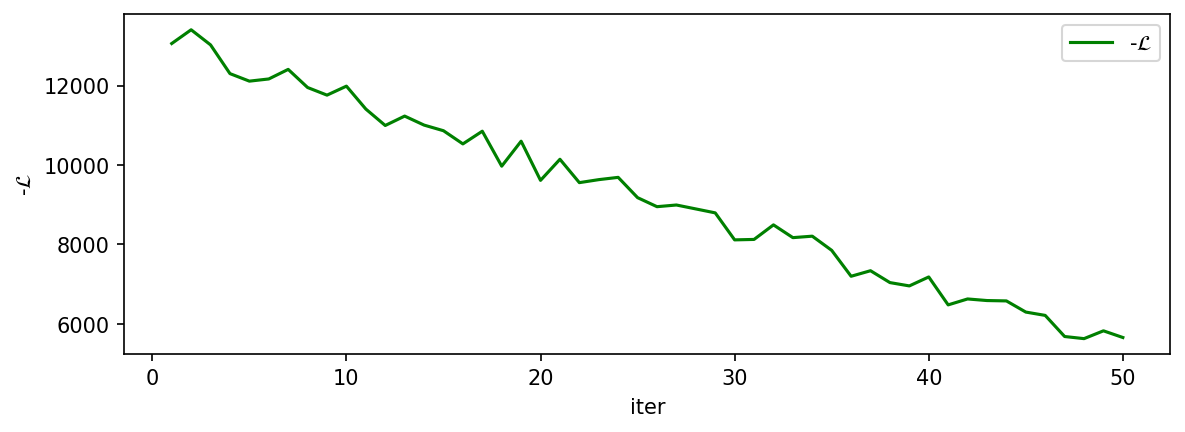

In [82]:
gen = Logic_Model_Generator()
num_sample = 48

data = gen.generate_data(num_sample=num_sample, time_horizon=3)
#print(data)
action_history = {}
for i in range(num_sample):
    action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
    action_history[i] = action_history_
#print(data)
learn = Logic_Model_Incomplete_Data(time_horizon=1,action_history=action_history,hidden_size=(15,10),output_size=(10,4),batch_size=16)
num_iter = 50
losses = learn.train_model(temperature=0.8,num_iter=num_iter,lr=(0.01,0.002))

X = np.arange(1,num_iter+1,1)
plt.figure(figsize=(9,3),dpi=150)
plt.plot(X, losses, c='green',label='-$\mathcal{L}$')
plt.xlabel('iter')
plt.ylabel('-$\mathcal{L}$')
plt.legend(bbox_to_anchor=(1,1))

[INFO] data has been generated!!!


  1%|          | 1/100 [00:28<46:46, 28.35s/it]

iter >> 1; loss >> [109883.836]
model parameter $\theta$ >> [tensor([-0.2701], dtype=torch.float64, requires_grad=True), tensor([-0.0166], dtype=torch.float64, requires_grad=True), tensor([0.0366], dtype=torch.float64, requires_grad=True), tensor([-0.2700], dtype=torch.float64, requires_grad=True), tensor([-0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0400], dtype=torch.float64, requires_grad=True), tensor([-0.1700], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1263], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2794], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5715], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0709], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, require

  2%|▏         | 2/100 [00:56<46:25, 28.42s/it]

iter >> 2; loss >> [102685.65]
model parameter $\theta$ >> [tensor([-0.2401], dtype=torch.float64, requires_grad=True), tensor([-0.0244], dtype=torch.float64, requires_grad=True), tensor([0.0444], dtype=torch.float64, requires_grad=True), tensor([-0.2401], dtype=torch.float64, requires_grad=True), tensor([-0.0396], dtype=torch.float64, requires_grad=True), tensor([0.0696], dtype=torch.float64, requires_grad=True), tensor([-0.1403], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1463], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3082], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5435], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0439], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

  3%|▎         | 3/100 [01:24<45:37, 28.23s/it]

iter >> 3; loss >> [105819.74]
model parameter $\theta$ >> [tensor([-0.2100], dtype=torch.float64, requires_grad=True), tensor([-0.0367], dtype=torch.float64, requires_grad=True), tensor([0.0567], dtype=torch.float64, requires_grad=True), tensor([-0.2104], dtype=torch.float64, requires_grad=True), tensor([-0.0697], dtype=torch.float64, requires_grad=True), tensor([0.0997], dtype=torch.float64, requires_grad=True), tensor([-0.1106], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1622], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3372], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5162], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0189], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

  4%|▍         | 4/100 [01:52<45:05, 28.18s/it]

iter >> 4; loss >> [99532.914]
model parameter $\theta$ >> [tensor([-0.1804], dtype=torch.float64, requires_grad=True), tensor([-0.0497], dtype=torch.float64, requires_grad=True), tensor([0.0697], dtype=torch.float64, requires_grad=True), tensor([-0.1805], dtype=torch.float64, requires_grad=True), tensor([-0.1001], dtype=torch.float64, requires_grad=True), tensor([0.1301], dtype=torch.float64, requires_grad=True), tensor([-0.0811], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1737], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3659], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4898], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0042], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

  5%|▌         | 5/100 [02:21<44:44, 28.26s/it]

iter >> 5; loss >> [102399.04]
model parameter $\theta$ >> [tensor([-0.1507], dtype=torch.float64, requires_grad=True), tensor([-0.0581], dtype=torch.float64, requires_grad=True), tensor([0.0781], dtype=torch.float64, requires_grad=True), tensor([-0.1505], dtype=torch.float64, requires_grad=True), tensor([-0.1306], dtype=torch.float64, requires_grad=True), tensor([0.1606], dtype=torch.float64, requires_grad=True), tensor([-0.0521], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1810], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3933], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4646], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0235], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

  6%|▌         | 6/100 [02:49<44:21, 28.31s/it]

iter >> 6; loss >> [98093.65]
model parameter $\theta$ >> [tensor([-0.1215], dtype=torch.float64, requires_grad=True), tensor([-0.0674], dtype=torch.float64, requires_grad=True), tensor([0.0874], dtype=torch.float64, requires_grad=True), tensor([-0.1209], dtype=torch.float64, requires_grad=True), tensor([-0.1604], dtype=torch.float64, requires_grad=True), tensor([0.1904], dtype=torch.float64, requires_grad=True), tensor([-0.0231], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1846], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4209], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4409], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0383], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

  7%|▋         | 7/100 [03:17<43:39, 28.17s/it]

iter >> 7; loss >> [96045.38]
model parameter $\theta$ >> [tensor([-0.0926], dtype=torch.float64, requires_grad=True), tensor([-0.0729], dtype=torch.float64, requires_grad=True), tensor([0.0929], dtype=torch.float64, requires_grad=True), tensor([-0.0916], dtype=torch.float64, requires_grad=True), tensor([-0.1901], dtype=torch.float64, requires_grad=True), tensor([0.2201], dtype=torch.float64, requires_grad=True), tensor([0.0058], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1854], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4486], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4192], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0480], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

  8%|▊         | 8/100 [03:46<43:22, 28.29s/it]

iter >> 8; loss >> [95896.46]
model parameter $\theta$ >> [tensor([-0.0647], dtype=torch.float64, requires_grad=True), tensor([-0.0874], dtype=torch.float64, requires_grad=True), tensor([0.1074], dtype=torch.float64, requires_grad=True), tensor([-0.0622], dtype=torch.float64, requires_grad=True), tensor([-0.2199], dtype=torch.float64, requires_grad=True), tensor([0.2499], dtype=torch.float64, requires_grad=True), tensor([0.0343], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1840], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4753], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3996], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0534], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

  9%|▉         | 9/100 [04:15<43:35, 28.74s/it]

iter >> 9; loss >> [95897.44]
model parameter $\theta$ >> [tensor([-0.0380], dtype=torch.float64, requires_grad=True), tensor([-0.1069], dtype=torch.float64, requires_grad=True), tensor([0.1269], dtype=torch.float64, requires_grad=True), tensor([-0.0328], dtype=torch.float64, requires_grad=True), tensor([-0.2494], dtype=torch.float64, requires_grad=True), tensor([0.2794], dtype=torch.float64, requires_grad=True), tensor([0.0620], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1813], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5014], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3824], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0537], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 10%|█         | 10/100 [04:44<43:11, 28.79s/it]

iter >> 10; loss >> [92994.664]
model parameter $\theta$ >> [tensor([-0.0112], dtype=torch.float64, requires_grad=True), tensor([-0.1284], dtype=torch.float64, requires_grad=True), tensor([0.1484], dtype=torch.float64, requires_grad=True), tensor([-0.0035], dtype=torch.float64, requires_grad=True), tensor([-0.2779], dtype=torch.float64, requires_grad=True), tensor([0.3079], dtype=torch.float64, requires_grad=True), tensor([0.0894], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1781], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5266], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3678], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0511], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 11%|█         | 11/100 [05:16<44:03, 29.71s/it]

iter >> 11; loss >> [91459.22]
model parameter $\theta$ >> [tensor([0.0156], dtype=torch.float64, requires_grad=True), tensor([-0.1524], dtype=torch.float64, requires_grad=True), tensor([0.1724], dtype=torch.float64, requires_grad=True), tensor([0.0251], dtype=torch.float64, requires_grad=True), tensor([-0.3064], dtype=torch.float64, requires_grad=True), tensor([0.3364], dtype=torch.float64, requires_grad=True), tensor([0.1169], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1748], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5516], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3560], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0461], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 12%|█▏        | 12/100 [05:48<44:28, 30.32s/it]

iter >> 12; loss >> [88460.125]
model parameter $\theta$ >> [tensor([0.0424], dtype=torch.float64, requires_grad=True), tensor([-0.1692], dtype=torch.float64, requires_grad=True), tensor([0.1892], dtype=torch.float64, requires_grad=True), tensor([0.0534], dtype=torch.float64, requires_grad=True), tensor([-0.3353], dtype=torch.float64, requires_grad=True), tensor([0.3653], dtype=torch.float64, requires_grad=True), tensor([0.1435], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1719], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5757], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3468], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0394], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 13%|█▎        | 13/100 [06:15<42:39, 29.42s/it]

iter >> 13; loss >> [87305.21]
model parameter $\theta$ >> [tensor([0.0692], dtype=torch.float64, requires_grad=True), tensor([-0.1819], dtype=torch.float64, requires_grad=True), tensor([0.2019], dtype=torch.float64, requires_grad=True), tensor([0.0818], dtype=torch.float64, requires_grad=True), tensor([-0.3647], dtype=torch.float64, requires_grad=True), tensor([0.3947], dtype=torch.float64, requires_grad=True), tensor([0.1696], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1697], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5987], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3401], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0332], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 14%|█▍        | 14/100 [06:42<41:11, 28.74s/it]

iter >> 14; loss >> [91717.33]
model parameter $\theta$ >> [tensor([0.0954], dtype=torch.float64, requires_grad=True), tensor([-0.1922], dtype=torch.float64, requires_grad=True), tensor([0.2122], dtype=torch.float64, requires_grad=True), tensor([0.1101], dtype=torch.float64, requires_grad=True), tensor([-0.3951], dtype=torch.float64, requires_grad=True), tensor([0.4251], dtype=torch.float64, requires_grad=True), tensor([0.1950], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1682], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.6206], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3357], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0277], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 15%|█▌        | 15/100 [07:11<40:32, 28.62s/it]

iter >> 15; loss >> [86126.58]
model parameter $\theta$ >> [tensor([0.1202], dtype=torch.float64, requires_grad=True), tensor([-0.2042], dtype=torch.float64, requires_grad=True), tensor([0.2242], dtype=torch.float64, requires_grad=True), tensor([0.1384], dtype=torch.float64, requires_grad=True), tensor([-0.4247], dtype=torch.float64, requires_grad=True), tensor([0.4547], dtype=torch.float64, requires_grad=True), tensor([0.2201], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1674], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.6424], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3334], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0246], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 16%|█▌        | 16/100 [07:38<39:29, 28.21s/it]

iter >> 16; loss >> [86090.195]
model parameter $\theta$ >> [tensor([0.1447], dtype=torch.float64, requires_grad=True), tensor([-0.2134], dtype=torch.float64, requires_grad=True), tensor([0.2334], dtype=torch.float64, requires_grad=True), tensor([0.1658], dtype=torch.float64, requires_grad=True), tensor([-0.4544], dtype=torch.float64, requires_grad=True), tensor([0.4844], dtype=torch.float64, requires_grad=True), tensor([0.2450], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1673], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.6639], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3327], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0228], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 17%|█▋        | 17/100 [08:07<39:11, 28.33s/it]

iter >> 17; loss >> [85800.89]
model parameter $\theta$ >> [tensor([0.1691], dtype=torch.float64, requires_grad=True), tensor([-0.2181], dtype=torch.float64, requires_grad=True), tensor([0.2381], dtype=torch.float64, requires_grad=True), tensor([0.1924], dtype=torch.float64, requires_grad=True), tensor([-0.4827], dtype=torch.float64, requires_grad=True), tensor([0.5127], dtype=torch.float64, requires_grad=True), tensor([0.2694], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1676], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.6842], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3333], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0217], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 18%|█▊        | 18/100 [08:34<38:22, 28.08s/it]

iter >> 18; loss >> [83701.3]
model parameter $\theta$ >> [tensor([0.1927], dtype=torch.float64, requires_grad=True), tensor([-0.2281], dtype=torch.float64, requires_grad=True), tensor([0.2481], dtype=torch.float64, requires_grad=True), tensor([0.2187], dtype=torch.float64, requires_grad=True), tensor([-0.5103], dtype=torch.float64, requires_grad=True), tensor([0.5403], dtype=torch.float64, requires_grad=True), tensor([0.2931], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1683], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.7038], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3348], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0219], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 19%|█▉        | 19/100 [09:01<37:37, 27.86s/it]

iter >> 19; loss >> [80076.51]
model parameter $\theta$ >> [tensor([0.2158], dtype=torch.float64, requires_grad=True), tensor([-0.2360], dtype=torch.float64, requires_grad=True), tensor([0.2560], dtype=torch.float64, requires_grad=True), tensor([0.2440], dtype=torch.float64, requires_grad=True), tensor([-0.5383], dtype=torch.float64, requires_grad=True), tensor([0.5683], dtype=torch.float64, requires_grad=True), tensor([0.3157], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1691], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.7217], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3370], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0207], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 20%|██        | 20/100 [09:29<37:12, 27.91s/it]

iter >> 20; loss >> [82001.16]
model parameter $\theta$ >> [tensor([0.2374], dtype=torch.float64, requires_grad=True), tensor([-0.2474], dtype=torch.float64, requires_grad=True), tensor([0.2674], dtype=torch.float64, requires_grad=True), tensor([0.2690], dtype=torch.float64, requires_grad=True), tensor([-0.5652], dtype=torch.float64, requires_grad=True), tensor([0.5952], dtype=torch.float64, requires_grad=True), tensor([0.3378], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1699], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.7393], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3395], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0210], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 21%|██        | 21/100 [10:01<38:03, 28.91s/it]

iter >> 21; loss >> [81820.484]
model parameter $\theta$ >> [tensor([0.2575], dtype=torch.float64, requires_grad=True), tensor([-0.2606], dtype=torch.float64, requires_grad=True), tensor([0.2806], dtype=torch.float64, requires_grad=True), tensor([0.2934], dtype=torch.float64, requires_grad=True), tensor([-0.5922], dtype=torch.float64, requires_grad=True), tensor([0.6222], dtype=torch.float64, requires_grad=True), tensor([0.3597], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.7568], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3420], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0222], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 22%|██▏       | 22/100 [10:29<37:29, 28.84s/it]

iter >> 22; loss >> [82642.13]
model parameter $\theta$ >> [tensor([0.2787], dtype=torch.float64, requires_grad=True), tensor([-0.2754], dtype=torch.float64, requires_grad=True), tensor([0.2954], dtype=torch.float64, requires_grad=True), tensor([0.3169], dtype=torch.float64, requires_grad=True), tensor([-0.6200], dtype=torch.float64, requires_grad=True), tensor([0.6500], dtype=torch.float64, requires_grad=True), tensor([0.3800], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1711], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.7726], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3445], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0213], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 23%|██▎       | 23/100 [10:59<37:17, 29.06s/it]

iter >> 23; loss >> [77722.875]
model parameter $\theta$ >> [tensor([0.3006], dtype=torch.float64, requires_grad=True), tensor([-0.2868], dtype=torch.float64, requires_grad=True), tensor([0.3068], dtype=torch.float64, requires_grad=True), tensor([0.3402], dtype=torch.float64, requires_grad=True), tensor([-0.6480], dtype=torch.float64, requires_grad=True), tensor([0.6780], dtype=torch.float64, requires_grad=True), tensor([0.3995], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1715], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.7871], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3467], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0199], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 24%|██▍       | 24/100 [11:28<36:41, 28.96s/it]

iter >> 24; loss >> [86233.48]
model parameter $\theta$ >> [tensor([0.3220], dtype=torch.float64, requires_grad=True), tensor([-0.2975], dtype=torch.float64, requires_grad=True), tensor([0.3175], dtype=torch.float64, requires_grad=True), tensor([0.3630], dtype=torch.float64, requires_grad=True), tensor([-0.6753], dtype=torch.float64, requires_grad=True), tensor([0.7053], dtype=torch.float64, requires_grad=True), tensor([0.4178], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1716], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8006], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3485], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0182], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 25%|██▌       | 25/100 [11:56<36:03, 28.85s/it]

iter >> 25; loss >> [80541.1]
model parameter $\theta$ >> [tensor([0.3418], dtype=torch.float64, requires_grad=True), tensor([-0.3136], dtype=torch.float64, requires_grad=True), tensor([0.3336], dtype=torch.float64, requires_grad=True), tensor([0.3863], dtype=torch.float64, requires_grad=True), tensor([-0.7014], dtype=torch.float64, requires_grad=True), tensor([0.7314], dtype=torch.float64, requires_grad=True), tensor([0.4354], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1716], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8142], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0186], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 26%|██▌       | 26/100 [12:25<35:26, 28.74s/it]

iter >> 26; loss >> [78110.83]
model parameter $\theta$ >> [tensor([0.3592], dtype=torch.float64, requires_grad=True), tensor([-0.3379], dtype=torch.float64, requires_grad=True), tensor([0.3579], dtype=torch.float64, requires_grad=True), tensor([0.4086], dtype=torch.float64, requires_grad=True), tensor([-0.7274], dtype=torch.float64, requires_grad=True), tensor([0.7574], dtype=torch.float64, requires_grad=True), tensor([0.4527], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1715], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8275], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3510], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0187], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 27%|██▋       | 27/100 [12:53<34:51, 28.65s/it]

iter >> 27; loss >> [77881.195]
model parameter $\theta$ >> [tensor([0.3754], dtype=torch.float64, requires_grad=True), tensor([-0.3624], dtype=torch.float64, requires_grad=True), tensor([0.3824], dtype=torch.float64, requires_grad=True), tensor([0.4305], dtype=torch.float64, requires_grad=True), tensor([-0.7540], dtype=torch.float64, requires_grad=True), tensor([0.7840], dtype=torch.float64, requires_grad=True), tensor([0.4690], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1714], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8398], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3518], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0184], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 28%|██▊       | 28/100 [13:23<34:47, 28.99s/it]

iter >> 28; loss >> [78156.125]
model parameter $\theta$ >> [tensor([0.3904], dtype=torch.float64, requires_grad=True), tensor([-0.3823], dtype=torch.float64, requires_grad=True), tensor([0.4023], dtype=torch.float64, requires_grad=True), tensor([0.4519], dtype=torch.float64, requires_grad=True), tensor([-0.7791], dtype=torch.float64, requires_grad=True), tensor([0.8091], dtype=torch.float64, requires_grad=True), tensor([0.4849], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1712], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8522], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3521], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0191], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 29%|██▉       | 29/100 [13:52<34:10, 28.88s/it]

iter >> 29; loss >> [79291.89]
model parameter $\theta$ >> [tensor([0.4049], dtype=torch.float64, requires_grad=True), tensor([-0.4013], dtype=torch.float64, requires_grad=True), tensor([0.4213], dtype=torch.float64, requires_grad=True), tensor([0.4728], dtype=torch.float64, requires_grad=True), tensor([-0.8038], dtype=torch.float64, requires_grad=True), tensor([0.8338], dtype=torch.float64, requires_grad=True), tensor([0.4998], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1710], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8640], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3523], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0185], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 30%|███       | 30/100 [14:24<34:55, 29.93s/it]

iter >> 30; loss >> [74542.88]
model parameter $\theta$ >> [tensor([0.4199], dtype=torch.float64, requires_grad=True), tensor([-0.4078], dtype=torch.float64, requires_grad=True), tensor([0.4278], dtype=torch.float64, requires_grad=True), tensor([0.4923], dtype=torch.float64, requires_grad=True), tensor([-0.8287], dtype=torch.float64, requires_grad=True), tensor([0.8587], dtype=torch.float64, requires_grad=True), tensor([0.5132], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8751], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3522], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0149], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 31%|███       | 31/100 [14:53<34:13, 29.76s/it]

iter >> 31; loss >> [75302.59]
model parameter $\theta$ >> [tensor([0.4349], dtype=torch.float64, requires_grad=True), tensor([-0.4122], dtype=torch.float64, requires_grad=True), tensor([0.4322], dtype=torch.float64, requires_grad=True), tensor([0.5114], dtype=torch.float64, requires_grad=True), tensor([-0.8538], dtype=torch.float64, requires_grad=True), tensor([0.8838], dtype=torch.float64, requires_grad=True), tensor([0.5246], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1707], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8841], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3519], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0106], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 32%|███▏      | 32/100 [15:23<33:42, 29.75s/it]

iter >> 32; loss >> [76565.58]
model parameter $\theta$ >> [tensor([0.4509], dtype=torch.float64, requires_grad=True), tensor([-0.4196], dtype=torch.float64, requires_grad=True), tensor([0.4396], dtype=torch.float64, requires_grad=True), tensor([0.5301], dtype=torch.float64, requires_grad=True), tensor([-0.8776], dtype=torch.float64, requires_grad=True), tensor([0.9076], dtype=torch.float64, requires_grad=True), tensor([0.5347], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.8921], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3516], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0079], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 33%|███▎      | 33/100 [15:52<32:52, 29.44s/it]

iter >> 33; loss >> [76293.43]
model parameter $\theta$ >> [tensor([0.4667], dtype=torch.float64, requires_grad=True), tensor([-0.4195], dtype=torch.float64, requires_grad=True), tensor([0.4395], dtype=torch.float64, requires_grad=True), tensor([0.5481], dtype=torch.float64, requires_grad=True), tensor([-0.9004], dtype=torch.float64, requires_grad=True), tensor([0.9304], dtype=torch.float64, requires_grad=True), tensor([0.5441], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9006], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3512], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0062], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 34%|███▍      | 34/100 [16:21<32:11, 29.27s/it]

iter >> 34; loss >> [77916.16]
model parameter $\theta$ >> [tensor([0.4811], dtype=torch.float64, requires_grad=True), tensor([-0.4223], dtype=torch.float64, requires_grad=True), tensor([0.4423], dtype=torch.float64, requires_grad=True), tensor([0.5651], dtype=torch.float64, requires_grad=True), tensor([-0.9224], dtype=torch.float64, requires_grad=True), tensor([0.9524], dtype=torch.float64, requires_grad=True), tensor([0.5544], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9093], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3509], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0073], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 35%|███▌      | 35/100 [16:49<31:28, 29.06s/it]

iter >> 35; loss >> [75232.47]
model parameter $\theta$ >> [tensor([0.4940], dtype=torch.float64, requires_grad=True), tensor([-0.4312], dtype=torch.float64, requires_grad=True), tensor([0.4512], dtype=torch.float64, requires_grad=True), tensor([0.5818], dtype=torch.float64, requires_grad=True), tensor([-0.9443], dtype=torch.float64, requires_grad=True), tensor([0.9743], dtype=torch.float64, requires_grad=True), tensor([0.5628], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9168], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3505], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0083], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 36%|███▌      | 36/100 [17:18<30:52, 28.94s/it]

iter >> 36; loss >> [75507.05]
model parameter $\theta$ >> [tensor([0.5065], dtype=torch.float64, requires_grad=True), tensor([-0.4441], dtype=torch.float64, requires_grad=True), tensor([0.4641], dtype=torch.float64, requires_grad=True), tensor([0.5978], dtype=torch.float64, requires_grad=True), tensor([-0.9665], dtype=torch.float64, requires_grad=True), tensor([0.9965], dtype=torch.float64, requires_grad=True), tensor([0.5690], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9233], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3502], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0073], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 37%|███▋      | 37/100 [17:46<30:05, 28.66s/it]

iter >> 37; loss >> [77600.72]
model parameter $\theta$ >> [tensor([0.5186], dtype=torch.float64, requires_grad=True), tensor([-0.4552], dtype=torch.float64, requires_grad=True), tensor([0.4752], dtype=torch.float64, requires_grad=True), tensor([0.6135], dtype=torch.float64, requires_grad=True), tensor([-0.9894], dtype=torch.float64, requires_grad=True), tensor([1.0194], dtype=torch.float64, requires_grad=True), tensor([0.5737], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1707], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9285], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0060], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 38%|███▊      | 38/100 [18:13<29:13, 28.29s/it]

iter >> 38; loss >> [76399.13]
model parameter $\theta$ >> [tensor([0.5295], dtype=torch.float64, requires_grad=True), tensor([-0.4645], dtype=torch.float64, requires_grad=True), tensor([0.4845], dtype=torch.float64, requires_grad=True), tensor([0.6289], dtype=torch.float64, requires_grad=True), tensor([-1.0110], dtype=torch.float64, requires_grad=True), tensor([1.0410], dtype=torch.float64, requires_grad=True), tensor([0.5775], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1707], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9338], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3498], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0051], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 39%|███▉      | 39/100 [18:41<28:27, 27.99s/it]

iter >> 39; loss >> [75982.45]
model parameter $\theta$ >> [tensor([0.5372], dtype=torch.float64, requires_grad=True), tensor([-0.4780], dtype=torch.float64, requires_grad=True), tensor([0.4980], dtype=torch.float64, requires_grad=True), tensor([0.6432], dtype=torch.float64, requires_grad=True), tensor([-1.0310], dtype=torch.float64, requires_grad=True), tensor([1.0610], dtype=torch.float64, requires_grad=True), tensor([0.5814], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9391], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3497], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0043], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 40%|████      | 40/100 [19:08<27:47, 27.79s/it]

iter >> 40; loss >> [76299.336]
model parameter $\theta$ >> [tensor([0.5423], dtype=torch.float64, requires_grad=True), tensor([-0.4903], dtype=torch.float64, requires_grad=True), tensor([0.5103], dtype=torch.float64, requires_grad=True), tensor([0.6561], dtype=torch.float64, requires_grad=True), tensor([-1.0500], dtype=torch.float64, requires_grad=True), tensor([1.0800], dtype=torch.float64, requires_grad=True), tensor([0.5866], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9448], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3496], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0043], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 41%|████      | 41/100 [19:36<27:17, 27.76s/it]

iter >> 41; loss >> [75378.16]
model parameter $\theta$ >> [tensor([0.5442], dtype=torch.float64, requires_grad=True), tensor([-0.5045], dtype=torch.float64, requires_grad=True), tensor([0.5245], dtype=torch.float64, requires_grad=True), tensor([0.6674], dtype=torch.float64, requires_grad=True), tensor([-1.0678], dtype=torch.float64, requires_grad=True), tensor([1.0978], dtype=torch.float64, requires_grad=True), tensor([0.5920], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9504], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3496], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0042], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 42%|████▏     | 42/100 [20:05<27:14, 28.19s/it]

iter >> 42; loss >> [76683.445]
model parameter $\theta$ >> [tensor([0.5450], dtype=torch.float64, requires_grad=True), tensor([-0.5160], dtype=torch.float64, requires_grad=True), tensor([0.5360], dtype=torch.float64, requires_grad=True), tensor([0.6779], dtype=torch.float64, requires_grad=True), tensor([-1.0866], dtype=torch.float64, requires_grad=True), tensor([1.1166], dtype=torch.float64, requires_grad=True), tensor([0.5985], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9566], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3496], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0056], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 43%|████▎     | 43/100 [20:32<26:29, 27.89s/it]

iter >> 43; loss >> [77576.07]
model parameter $\theta$ >> [tensor([0.5433], dtype=torch.float64, requires_grad=True), tensor([-0.5280], dtype=torch.float64, requires_grad=True), tensor([0.5480], dtype=torch.float64, requires_grad=True), tensor([0.6883], dtype=torch.float64, requires_grad=True), tensor([-1.1049], dtype=torch.float64, requires_grad=True), tensor([1.1349], dtype=torch.float64, requires_grad=True), tensor([0.6048], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9631], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3496], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0085], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 44%|████▍     | 44/100 [21:02<26:42, 28.61s/it]

iter >> 44; loss >> [74256.73]
model parameter $\theta$ >> [tensor([0.5385], dtype=torch.float64, requires_grad=True), tensor([-0.5413], dtype=torch.float64, requires_grad=True), tensor([0.5613], dtype=torch.float64, requires_grad=True), tensor([0.6991], dtype=torch.float64, requires_grad=True), tensor([-1.1240], dtype=torch.float64, requires_grad=True), tensor([1.1540], dtype=torch.float64, requires_grad=True), tensor([0.6112], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9698], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3497], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0126], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 45%|████▌     | 45/100 [21:33<26:51, 29.30s/it]

iter >> 45; loss >> [74932.88]
model parameter $\theta$ >> [tensor([0.5319], dtype=torch.float64, requires_grad=True), tensor([-0.5516], dtype=torch.float64, requires_grad=True), tensor([0.5716], dtype=torch.float64, requires_grad=True), tensor([0.7099], dtype=torch.float64, requires_grad=True), tensor([-1.1426], dtype=torch.float64, requires_grad=True), tensor([1.1726], dtype=torch.float64, requires_grad=True), tensor([0.6172], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9755], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3497], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0167], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 46%|████▌     | 46/100 [22:02<26:12, 29.13s/it]

iter >> 46; loss >> [74973.95]
model parameter $\theta$ >> [tensor([0.5261], dtype=torch.float64, requires_grad=True), tensor([-0.5616], dtype=torch.float64, requires_grad=True), tensor([0.5816], dtype=torch.float64, requires_grad=True), tensor([0.7197], dtype=torch.float64, requires_grad=True), tensor([-1.1610], dtype=torch.float64, requires_grad=True), tensor([1.1910], dtype=torch.float64, requires_grad=True), tensor([0.6228], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9822], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3498], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0188], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 47%|████▋     | 47/100 [22:31<25:44, 29.14s/it]

iter >> 47; loss >> [75253.41]
model parameter $\theta$ >> [tensor([0.5216], dtype=torch.float64, requires_grad=True), tensor([-0.5724], dtype=torch.float64, requires_grad=True), tensor([0.5924], dtype=torch.float64, requires_grad=True), tensor([0.7294], dtype=torch.float64, requires_grad=True), tensor([-1.1800], dtype=torch.float64, requires_grad=True), tensor([1.2100], dtype=torch.float64, requires_grad=True), tensor([0.6279], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9892], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0204], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 48%|████▊     | 48/100 [23:00<25:15, 29.13s/it]

iter >> 48; loss >> [74445.72]
model parameter $\theta$ >> [tensor([0.5188], dtype=torch.float64, requires_grad=True), tensor([-0.5756], dtype=torch.float64, requires_grad=True), tensor([0.5956], dtype=torch.float64, requires_grad=True), tensor([0.7388], dtype=torch.float64, requires_grad=True), tensor([-1.1987], dtype=torch.float64, requires_grad=True), tensor([1.2287], dtype=torch.float64, requires_grad=True), tensor([0.6324], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.9957], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0210], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 49%|████▉     | 49/100 [23:29<24:41, 29.05s/it]

iter >> 49; loss >> [74563.43]
model parameter $\theta$ >> [tensor([0.5157], dtype=torch.float64, requires_grad=True), tensor([-0.5806], dtype=torch.float64, requires_grad=True), tensor([0.6006], dtype=torch.float64, requires_grad=True), tensor([0.7479], dtype=torch.float64, requires_grad=True), tensor([-1.2174], dtype=torch.float64, requires_grad=True), tensor([1.2474], dtype=torch.float64, requires_grad=True), tensor([0.6372], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0025], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0213], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 50%|█████     | 50/100 [23:58<24:07, 28.94s/it]

iter >> 50; loss >> [75855.93]
model parameter $\theta$ >> [tensor([0.5130], dtype=torch.float64, requires_grad=True), tensor([-0.5828], dtype=torch.float64, requires_grad=True), tensor([0.6028], dtype=torch.float64, requires_grad=True), tensor([0.7559], dtype=torch.float64, requires_grad=True), tensor([-1.2367], dtype=torch.float64, requires_grad=True), tensor([1.2667], dtype=torch.float64, requires_grad=True), tensor([0.6422], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0098], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0204], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 51%|█████     | 51/100 [24:26<23:32, 28.82s/it]

iter >> 51; loss >> [75032.125]
model parameter $\theta$ >> [tensor([0.5097], dtype=torch.float64, requires_grad=True), tensor([-0.5856], dtype=torch.float64, requires_grad=True), tensor([0.6056], dtype=torch.float64, requires_grad=True), tensor([0.7648], dtype=torch.float64, requires_grad=True), tensor([-1.2564], dtype=torch.float64, requires_grad=True), tensor([1.2864], dtype=torch.float64, requires_grad=True), tensor([0.6454], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0155], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0195], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 52%|█████▏    | 52/100 [24:55<23:01, 28.78s/it]

iter >> 52; loss >> [74810.36]
model parameter $\theta$ >> [tensor([0.5065], dtype=torch.float64, requires_grad=True), tensor([-0.5873], dtype=torch.float64, requires_grad=True), tensor([0.6073], dtype=torch.float64, requires_grad=True), tensor([0.7733], dtype=torch.float64, requires_grad=True), tensor([-1.2748], dtype=torch.float64, requires_grad=True), tensor([1.3048], dtype=torch.float64, requires_grad=True), tensor([0.6471], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0196], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0174], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 53%|█████▎    | 53/100 [25:25<22:49, 29.15s/it]

iter >> 53; loss >> [76211.82]
model parameter $\theta$ >> [tensor([0.5047], dtype=torch.float64, requires_grad=True), tensor([-0.5942], dtype=torch.float64, requires_grad=True), tensor([0.6142], dtype=torch.float64, requires_grad=True), tensor([0.7813], dtype=torch.float64, requires_grad=True), tensor([-1.2926], dtype=torch.float64, requires_grad=True), tensor([1.3226], dtype=torch.float64, requires_grad=True), tensor([0.6482], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0235], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0144], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 54%|█████▍    | 54/100 [25:54<22:13, 28.98s/it]

iter >> 54; loss >> [76945.43]
model parameter $\theta$ >> [tensor([0.5026], dtype=torch.float64, requires_grad=True), tensor([-0.6028], dtype=torch.float64, requires_grad=True), tensor([0.6228], dtype=torch.float64, requires_grad=True), tensor([0.7885], dtype=torch.float64, requires_grad=True), tensor([-1.3113], dtype=torch.float64, requires_grad=True), tensor([1.3413], dtype=torch.float64, requires_grad=True), tensor([0.6500], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0287], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0128], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 55%|█████▌    | 55/100 [26:22<21:38, 28.85s/it]

iter >> 55; loss >> [74818.266]
model parameter $\theta$ >> [tensor([0.5025], dtype=torch.float64, requires_grad=True), tensor([-0.6103], dtype=torch.float64, requires_grad=True), tensor([0.6303], dtype=torch.float64, requires_grad=True), tensor([0.7945], dtype=torch.float64, requires_grad=True), tensor([-1.3297], dtype=torch.float64, requires_grad=True), tensor([1.3597], dtype=torch.float64, requires_grad=True), tensor([0.6515], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0338], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0101], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 56%|█████▌    | 56/100 [26:51<21:07, 28.80s/it]

iter >> 56; loss >> [74086.03]
model parameter $\theta$ >> [tensor([0.5035], dtype=torch.float64, requires_grad=True), tensor([-0.6130], dtype=torch.float64, requires_grad=True), tensor([0.6330], dtype=torch.float64, requires_grad=True), tensor([0.7995], dtype=torch.float64, requires_grad=True), tensor([-1.3482], dtype=torch.float64, requires_grad=True), tensor([1.3782], dtype=torch.float64, requires_grad=True), tensor([0.6526], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0378], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0077], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 57%|█████▋    | 57/100 [27:19<20:36, 28.76s/it]

iter >> 57; loss >> [76151.37]
model parameter $\theta$ >> [tensor([0.5048], dtype=torch.float64, requires_grad=True), tensor([-0.6121], dtype=torch.float64, requires_grad=True), tensor([0.6321], dtype=torch.float64, requires_grad=True), tensor([0.8053], dtype=torch.float64, requires_grad=True), tensor([-1.3663], dtype=torch.float64, requires_grad=True), tensor([1.3963], dtype=torch.float64, requires_grad=True), tensor([0.6530], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0413], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0079], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 58%|█████▊    | 58/100 [27:48<20:06, 28.72s/it]

iter >> 58; loss >> [75995.42]
model parameter $\theta$ >> [tensor([0.5062], dtype=torch.float64, requires_grad=True), tensor([-0.6136], dtype=torch.float64, requires_grad=True), tensor([0.6336], dtype=torch.float64, requires_grad=True), tensor([0.8107], dtype=torch.float64, requires_grad=True), tensor([-1.3839], dtype=torch.float64, requires_grad=True), tensor([1.4139], dtype=torch.float64, requires_grad=True), tensor([0.6534], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0447], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0097], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 59%|█████▉    | 59/100 [28:18<19:46, 28.95s/it]

iter >> 59; loss >> [75936.36]
model parameter $\theta$ >> [tensor([0.5078], dtype=torch.float64, requires_grad=True), tensor([-0.6166], dtype=torch.float64, requires_grad=True), tensor([0.6366], dtype=torch.float64, requires_grad=True), tensor([0.8152], dtype=torch.float64, requires_grad=True), tensor([-1.4005], dtype=torch.float64, requires_grad=True), tensor([1.4305], dtype=torch.float64, requires_grad=True), tensor([0.6544], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0484], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0115], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 60%|██████    | 60/100 [28:46<19:13, 28.83s/it]

iter >> 60; loss >> [77408.7]
model parameter $\theta$ >> [tensor([0.5073], dtype=torch.float64, requires_grad=True), tensor([-0.6251], dtype=torch.float64, requires_grad=True), tensor([0.6451], dtype=torch.float64, requires_grad=True), tensor([0.8193], dtype=torch.float64, requires_grad=True), tensor([-1.4170], dtype=torch.float64, requires_grad=True), tensor([1.4470], dtype=torch.float64, requires_grad=True), tensor([0.6564], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0540], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0137], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 61%|██████    | 61/100 [29:15<18:44, 28.84s/it]

iter >> 61; loss >> [74543.65]
model parameter $\theta$ >> [tensor([0.5067], dtype=torch.float64, requires_grad=True), tensor([-0.6331], dtype=torch.float64, requires_grad=True), tensor([0.6531], dtype=torch.float64, requires_grad=True), tensor([0.8230], dtype=torch.float64, requires_grad=True), tensor([-1.4336], dtype=torch.float64, requires_grad=True), tensor([1.4636], dtype=torch.float64, requires_grad=True), tensor([0.6577], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0585], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0151], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 62%|██████▏   | 62/100 [29:44<18:16, 28.85s/it]

iter >> 62; loss >> [75729.42]
model parameter $\theta$ >> [tensor([0.5061], dtype=torch.float64, requires_grad=True), tensor([-0.6423], dtype=torch.float64, requires_grad=True), tensor([0.6623], dtype=torch.float64, requires_grad=True), tensor([0.8271], dtype=torch.float64, requires_grad=True), tensor([-1.4498], dtype=torch.float64, requires_grad=True), tensor([1.4798], dtype=torch.float64, requires_grad=True), tensor([0.6571], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0610], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0146], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 63%|██████▎   | 63/100 [30:11<17:29, 28.38s/it]

iter >> 63; loss >> [73359.375]
model parameter $\theta$ >> [tensor([0.5060], dtype=torch.float64, requires_grad=True), tensor([-0.6541], dtype=torch.float64, requires_grad=True), tensor([0.6741], dtype=torch.float64, requires_grad=True), tensor([0.8311], dtype=torch.float64, requires_grad=True), tensor([-1.4652], dtype=torch.float64, requires_grad=True), tensor([1.4952], dtype=torch.float64, requires_grad=True), tensor([0.6560], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0633], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0142], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 64%|██████▍   | 64/100 [30:43<17:41, 29.48s/it]

iter >> 64; loss >> [75453.45]
model parameter $\theta$ >> [tensor([0.5064], dtype=torch.float64, requires_grad=True), tensor([-0.6646], dtype=torch.float64, requires_grad=True), tensor([0.6846], dtype=torch.float64, requires_grad=True), tensor([0.8341], dtype=torch.float64, requires_grad=True), tensor([-1.4802], dtype=torch.float64, requires_grad=True), tensor([1.5102], dtype=torch.float64, requires_grad=True), tensor([0.6541], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0644], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0122], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 65%|██████▌   | 65/100 [31:15<17:37, 30.21s/it]

iter >> 65; loss >> [76106.47]
model parameter $\theta$ >> [tensor([0.5058], dtype=torch.float64, requires_grad=True), tensor([-0.6768], dtype=torch.float64, requires_grad=True), tensor([0.6968], dtype=torch.float64, requires_grad=True), tensor([0.8357], dtype=torch.float64, requires_grad=True), tensor([-1.4946], dtype=torch.float64, requires_grad=True), tensor([1.5246], dtype=torch.float64, requires_grad=True), tensor([0.6525], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0662], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0090], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 66%|██████▌   | 66/100 [31:45<17:09, 30.27s/it]

iter >> 66; loss >> [75057.234]
model parameter $\theta$ >> [tensor([0.5080], dtype=torch.float64, requires_grad=True), tensor([-0.6850], dtype=torch.float64, requires_grad=True), tensor([0.7050], dtype=torch.float64, requires_grad=True), tensor([0.8358], dtype=torch.float64, requires_grad=True), tensor([-1.5084], dtype=torch.float64, requires_grad=True), tensor([1.5384], dtype=torch.float64, requires_grad=True), tensor([0.6509], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0676], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0050], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 67%|██████▋   | 67/100 [32:14<16:22, 29.78s/it]

iter >> 67; loss >> [77212.055]
model parameter $\theta$ >> [tensor([0.5128], dtype=torch.float64, requires_grad=True), tensor([-0.6961], dtype=torch.float64, requires_grad=True), tensor([0.7161], dtype=torch.float64, requires_grad=True), tensor([0.8363], dtype=torch.float64, requires_grad=True), tensor([-1.5215], dtype=torch.float64, requires_grad=True), tensor([1.5515], dtype=torch.float64, requires_grad=True), tensor([0.6490], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0685], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0024], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 68%|██████▊   | 68/100 [32:43<15:41, 29.43s/it]

iter >> 68; loss >> [74625.07]
model parameter $\theta$ >> [tensor([0.5148], dtype=torch.float64, requires_grad=True), tensor([-0.7104], dtype=torch.float64, requires_grad=True), tensor([0.7304], dtype=torch.float64, requires_grad=True), tensor([0.8380], dtype=torch.float64, requires_grad=True), tensor([-1.5344], dtype=torch.float64, requires_grad=True), tensor([1.5644], dtype=torch.float64, requires_grad=True), tensor([0.6470], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0701], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0025], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 69%|██████▉   | 69/100 [33:11<15:05, 29.21s/it]

iter >> 69; loss >> [78238.38]
model parameter $\theta$ >> [tensor([0.5148], dtype=torch.float64, requires_grad=True), tensor([-0.7205], dtype=torch.float64, requires_grad=True), tensor([0.7405], dtype=torch.float64, requires_grad=True), tensor([0.8390], dtype=torch.float64, requires_grad=True), tensor([-1.5469], dtype=torch.float64, requires_grad=True), tensor([1.5769], dtype=torch.float64, requires_grad=True), tensor([0.6455], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0710], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0032], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 70%|███████   | 70/100 [33:40<14:30, 29.02s/it]

iter >> 70; loss >> [76641.516]
model parameter $\theta$ >> [tensor([0.5147], dtype=torch.float64, requires_grad=True), tensor([-0.7302], dtype=torch.float64, requires_grad=True), tensor([0.7502], dtype=torch.float64, requires_grad=True), tensor([0.8387], dtype=torch.float64, requires_grad=True), tensor([-1.5591], dtype=torch.float64, requires_grad=True), tensor([1.5891], dtype=torch.float64, requires_grad=True), tensor([0.6445], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0721], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3499], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0032], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 71%|███████   | 71/100 [34:09<13:57, 28.88s/it]

iter >> 71; loss >> [77992.18]
model parameter $\theta$ >> [tensor([0.5140], dtype=torch.float64, requires_grad=True), tensor([-0.7401], dtype=torch.float64, requires_grad=True), tensor([0.7601], dtype=torch.float64, requires_grad=True), tensor([0.8380], dtype=torch.float64, requires_grad=True), tensor([-1.5708], dtype=torch.float64, requires_grad=True), tensor([1.6008], dtype=torch.float64, requires_grad=True), tensor([0.6452], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0742], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0050], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 72%|███████▏  | 72/100 [34:37<13:26, 28.79s/it]

iter >> 72; loss >> [76481.19]
model parameter $\theta$ >> [tensor([0.5115], dtype=torch.float64, requires_grad=True), tensor([-0.7478], dtype=torch.float64, requires_grad=True), tensor([0.7678], dtype=torch.float64, requires_grad=True), tensor([0.8377], dtype=torch.float64, requires_grad=True), tensor([-1.5826], dtype=torch.float64, requires_grad=True), tensor([1.6126], dtype=torch.float64, requires_grad=True), tensor([0.6461], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0770], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0077], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 73%|███████▎  | 73/100 [35:07<13:06, 29.13s/it]

iter >> 73; loss >> [76549.4]
model parameter $\theta$ >> [tensor([0.5079], dtype=torch.float64, requires_grad=True), tensor([-0.7566], dtype=torch.float64, requires_grad=True), tensor([0.7766], dtype=torch.float64, requires_grad=True), tensor([0.8389], dtype=torch.float64, requires_grad=True), tensor([-1.5948], dtype=torch.float64, requires_grad=True), tensor([1.6248], dtype=torch.float64, requires_grad=True), tensor([0.6469], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0794], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0123], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 74%|███████▍  | 74/100 [35:37<12:46, 29.47s/it]

iter >> 74; loss >> [75788.63]
model parameter $\theta$ >> [tensor([0.5037], dtype=torch.float64, requires_grad=True), tensor([-0.7686], dtype=torch.float64, requires_grad=True), tensor([0.7886], dtype=torch.float64, requires_grad=True), tensor([0.8391], dtype=torch.float64, requires_grad=True), tensor([-1.6068], dtype=torch.float64, requires_grad=True), tensor([1.6368], dtype=torch.float64, requires_grad=True), tensor([0.6493], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0821], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0165], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 75%|███████▌  | 75/100 [36:06<12:11, 29.25s/it]

iter >> 75; loss >> [77418.69]
model parameter $\theta$ >> [tensor([0.5012], dtype=torch.float64, requires_grad=True), tensor([-0.7793], dtype=torch.float64, requires_grad=True), tensor([0.7993], dtype=torch.float64, requires_grad=True), tensor([0.8375], dtype=torch.float64, requires_grad=True), tensor([-1.6184], dtype=torch.float64, requires_grad=True), tensor([1.6484], dtype=torch.float64, requires_grad=True), tensor([0.6523], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0860], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0175], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 76%|███████▌  | 76/100 [36:35<11:38, 29.09s/it]

iter >> 76; loss >> [77230.54]
model parameter $\theta$ >> [tensor([0.4979], dtype=torch.float64, requires_grad=True), tensor([-0.7871], dtype=torch.float64, requires_grad=True), tensor([0.8071], dtype=torch.float64, requires_grad=True), tensor([0.8357], dtype=torch.float64, requires_grad=True), tensor([-1.6290], dtype=torch.float64, requires_grad=True), tensor([1.6590], dtype=torch.float64, requires_grad=True), tensor([0.6565], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0918], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0180], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 77%|███████▋  | 77/100 [37:03<11:05, 28.95s/it]

iter >> 77; loss >> [74672.68]
model parameter $\theta$ >> [tensor([0.4941], dtype=torch.float64, requires_grad=True), tensor([-0.7925], dtype=torch.float64, requires_grad=True), tensor([0.8125], dtype=torch.float64, requires_grad=True), tensor([0.8346], dtype=torch.float64, requires_grad=True), tensor([-1.6396], dtype=torch.float64, requires_grad=True), tensor([1.6696], dtype=torch.float64, requires_grad=True), tensor([0.6602], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.0963], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0178], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 78%|███████▊  | 78/100 [37:32<10:35, 28.87s/it]

iter >> 78; loss >> [77196.68]
model parameter $\theta$ >> [tensor([0.4926], dtype=torch.float64, requires_grad=True), tensor([-0.7985], dtype=torch.float64, requires_grad=True), tensor([0.8185], dtype=torch.float64, requires_grad=True), tensor([0.8338], dtype=torch.float64, requires_grad=True), tensor([-1.6496], dtype=torch.float64, requires_grad=True), tensor([1.6796], dtype=torch.float64, requires_grad=True), tensor([0.6627], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1006], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0155], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 79%|███████▉  | 79/100 [38:01<10:06, 28.87s/it]

iter >> 79; loss >> [75879.97]
model parameter $\theta$ >> [tensor([0.4918], dtype=torch.float64, requires_grad=True), tensor([-0.8023], dtype=torch.float64, requires_grad=True), tensor([0.8223], dtype=torch.float64, requires_grad=True), tensor([0.8325], dtype=torch.float64, requires_grad=True), tensor([-1.6601], dtype=torch.float64, requires_grad=True), tensor([1.6901], dtype=torch.float64, requires_grad=True), tensor([0.6650], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1045], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0125], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 80%|████████  | 80/100 [38:29<09:35, 28.77s/it]

iter >> 80; loss >> [75760.96]
model parameter $\theta$ >> [tensor([0.4907], dtype=torch.float64, requires_grad=True), tensor([-0.8083], dtype=torch.float64, requires_grad=True), tensor([0.8283], dtype=torch.float64, requires_grad=True), tensor([0.8308], dtype=torch.float64, requires_grad=True), tensor([-1.6704], dtype=torch.float64, requires_grad=True), tensor([1.7004], dtype=torch.float64, requires_grad=True), tensor([0.6668], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1078], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0090], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 81%|████████  | 81/100 [38:58<09:05, 28.71s/it]

iter >> 81; loss >> [76959.984]
model parameter $\theta$ >> [tensor([0.4914], dtype=torch.float64, requires_grad=True), tensor([-0.8161], dtype=torch.float64, requires_grad=True), tensor([0.8361], dtype=torch.float64, requires_grad=True), tensor([0.8288], dtype=torch.float64, requires_grad=True), tensor([-1.6811], dtype=torch.float64, requires_grad=True), tensor([1.7111], dtype=torch.float64, requires_grad=True), tensor([0.6683], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1105], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0065], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 82%|████████▏ | 82/100 [39:26<08:35, 28.62s/it]

iter >> 82; loss >> [76175.11]
model parameter $\theta$ >> [tensor([0.4904], dtype=torch.float64, requires_grad=True), tensor([-0.8244], dtype=torch.float64, requires_grad=True), tensor([0.8444], dtype=torch.float64, requires_grad=True), tensor([0.8280], dtype=torch.float64, requires_grad=True), tensor([-1.6916], dtype=torch.float64, requires_grad=True), tensor([1.7216], dtype=torch.float64, requires_grad=True), tensor([0.6689], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1122], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0060], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 83%|████████▎ | 83/100 [39:54<07:59, 28.19s/it]

iter >> 83; loss >> [77106.81]
model parameter $\theta$ >> [tensor([0.4882], dtype=torch.float64, requires_grad=True), tensor([-0.8294], dtype=torch.float64, requires_grad=True), tensor([0.8494], dtype=torch.float64, requires_grad=True), tensor([0.8276], dtype=torch.float64, requires_grad=True), tensor([-1.7021], dtype=torch.float64, requires_grad=True), tensor([1.7321], dtype=torch.float64, requires_grad=True), tensor([0.6693], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1136], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0067], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 84%|████████▍ | 84/100 [40:21<07:26, 27.90s/it]

iter >> 84; loss >> [76875.33]
model parameter $\theta$ >> [tensor([0.4856], dtype=torch.float64, requires_grad=True), tensor([-0.8354], dtype=torch.float64, requires_grad=True), tensor([0.8554], dtype=torch.float64, requires_grad=True), tensor([0.8283], dtype=torch.float64, requires_grad=True), tensor([-1.7120], dtype=torch.float64, requires_grad=True), tensor([1.7420], dtype=torch.float64, requires_grad=True), tensor([0.6704], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1150], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0108], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 85%|████████▌ | 85/100 [40:48<06:55, 27.68s/it]

iter >> 85; loss >> [76786.484]
model parameter $\theta$ >> [tensor([0.4829], dtype=torch.float64, requires_grad=True), tensor([-0.8352], dtype=torch.float64, requires_grad=True), tensor([0.8552], dtype=torch.float64, requires_grad=True), tensor([0.8304], dtype=torch.float64, requires_grad=True), tensor([-1.7215], dtype=torch.float64, requires_grad=True), tensor([1.7515], dtype=torch.float64, requires_grad=True), tensor([0.6705], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1161], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0155], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 86%|████████▌ | 86/100 [41:17<06:34, 28.18s/it]

iter >> 86; loss >> [76290.71]
model parameter $\theta$ >> [tensor([0.4812], dtype=torch.float64, requires_grad=True), tensor([-0.8358], dtype=torch.float64, requires_grad=True), tensor([0.8558], dtype=torch.float64, requires_grad=True), tensor([0.8330], dtype=torch.float64, requires_grad=True), tensor([-1.7310], dtype=torch.float64, requires_grad=True), tensor([1.7610], dtype=torch.float64, requires_grad=True), tensor([0.6704], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1169], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0193], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 87%|████████▋ | 87/100 [41:45<06:02, 27.92s/it]

iter >> 87; loss >> [76886.12]
model parameter $\theta$ >> [tensor([0.4798], dtype=torch.float64, requires_grad=True), tensor([-0.8375], dtype=torch.float64, requires_grad=True), tensor([0.8575], dtype=torch.float64, requires_grad=True), tensor([0.8363], dtype=torch.float64, requires_grad=True), tensor([-1.7403], dtype=torch.float64, requires_grad=True), tensor([1.7703], dtype=torch.float64, requires_grad=True), tensor([0.6695], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1167], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0223], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 88%|████████▊ | 88/100 [42:13<05:35, 27.94s/it]

iter >> 88; loss >> [74431.766]
model parameter $\theta$ >> [tensor([0.4797], dtype=torch.float64, requires_grad=True), tensor([-0.8438], dtype=torch.float64, requires_grad=True), tensor([0.8638], dtype=torch.float64, requires_grad=True), tensor([0.8391], dtype=torch.float64, requires_grad=True), tensor([-1.7494], dtype=torch.float64, requires_grad=True), tensor([1.7794], dtype=torch.float64, requires_grad=True), tensor([0.6695], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1180], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0240], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 89%|████████▉ | 89/100 [42:40<05:04, 27.71s/it]

iter >> 89; loss >> [75976.21]
model parameter $\theta$ >> [tensor([0.4803], dtype=torch.float64, requires_grad=True), tensor([-0.8505], dtype=torch.float64, requires_grad=True), tensor([0.8705], dtype=torch.float64, requires_grad=True), tensor([0.8421], dtype=torch.float64, requires_grad=True), tensor([-1.7584], dtype=torch.float64, requires_grad=True), tensor([1.7884], dtype=torch.float64, requires_grad=True), tensor([0.6692], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1183], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0240], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 90%|█████████ | 90/100 [43:09<04:41, 28.10s/it]

iter >> 90; loss >> [77793.516]
model parameter $\theta$ >> [tensor([0.4797], dtype=torch.float64, requires_grad=True), tensor([-0.8554], dtype=torch.float64, requires_grad=True), tensor([0.8754], dtype=torch.float64, requires_grad=True), tensor([0.8454], dtype=torch.float64, requires_grad=True), tensor([-1.7671], dtype=torch.float64, requires_grad=True), tensor([1.7971], dtype=torch.float64, requires_grad=True), tensor([0.6683], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1177], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0228], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 91%|█████████ | 91/100 [43:39<04:18, 28.75s/it]

iter >> 91; loss >> [76007.664]
model parameter $\theta$ >> [tensor([0.4813], dtype=torch.float64, requires_grad=True), tensor([-0.8635], dtype=torch.float64, requires_grad=True), tensor([0.8835], dtype=torch.float64, requires_grad=True), tensor([0.8477], dtype=torch.float64, requires_grad=True), tensor([-1.7763], dtype=torch.float64, requires_grad=True), tensor([1.8063], dtype=torch.float64, requires_grad=True), tensor([0.6685], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1187], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0209], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 92%|█████████▏| 92/100 [44:12<03:59, 29.99s/it]

iter >> 92; loss >> [74091.125]
model parameter $\theta$ >> [tensor([0.4842], dtype=torch.float64, requires_grad=True), tensor([-0.8655], dtype=torch.float64, requires_grad=True), tensor([0.8855], dtype=torch.float64, requires_grad=True), tensor([0.8495], dtype=torch.float64, requires_grad=True), tensor([-1.7849], dtype=torch.float64, requires_grad=True), tensor([1.8149], dtype=torch.float64, requires_grad=True), tensor([0.6700], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1204], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0194], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 93%|█████████▎| 93/100 [44:41<03:27, 29.69s/it]

iter >> 93; loss >> [73464.37]
model parameter $\theta$ >> [tensor([0.4862], dtype=torch.float64, requires_grad=True), tensor([-0.8681], dtype=torch.float64, requires_grad=True), tensor([0.8881], dtype=torch.float64, requires_grad=True), tensor([0.8528], dtype=torch.float64, requires_grad=True), tensor([-1.7932], dtype=torch.float64, requires_grad=True), tensor([1.8232], dtype=torch.float64, requires_grad=True), tensor([0.6712], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1217], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 94%|█████████▍| 94/100 [45:10<02:57, 29.55s/it]

iter >> 94; loss >> [75116.65]
model parameter $\theta$ >> [tensor([0.4902], dtype=torch.float64, requires_grad=True), tensor([-0.8723], dtype=torch.float64, requires_grad=True), tensor([0.8923], dtype=torch.float64, requires_grad=True), tensor([0.8565], dtype=torch.float64, requires_grad=True), tensor([-1.8014], dtype=torch.float64, requires_grad=True), tensor([1.8314], dtype=torch.float64, requires_grad=True), tensor([0.6705], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1209], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 95%|█████████▌| 95/100 [45:39<02:26, 29.25s/it]

iter >> 95; loss >> [76151.664]
model parameter $\theta$ >> [tensor([0.4956], dtype=torch.float64, requires_grad=True), tensor([-0.8777], dtype=torch.float64, requires_grad=True), tensor([0.8977], dtype=torch.float64, requires_grad=True), tensor([0.8580], dtype=torch.float64, requires_grad=True), tensor([-1.8097], dtype=torch.float64, requires_grad=True), tensor([1.8397], dtype=torch.float64, requires_grad=True), tensor([0.6709], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1213], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0186], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 96%|█████████▌| 96/100 [46:07<01:56, 29.07s/it]

iter >> 96; loss >> [76212.4]
model parameter $\theta$ >> [tensor([0.5012], dtype=torch.float64, requires_grad=True), tensor([-0.8831], dtype=torch.float64, requires_grad=True), tensor([0.9031], dtype=torch.float64, requires_grad=True), tensor([0.8588], dtype=torch.float64, requires_grad=True), tensor([-1.8179], dtype=torch.float64, requires_grad=True), tensor([1.8479], dtype=torch.float64, requires_grad=True), tensor([0.6708], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1210], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0164], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 97%|█████████▋| 97/100 [46:37<01:27, 29.17s/it]

iter >> 97; loss >> [76482.67]
model parameter $\theta$ >> [tensor([0.5089], dtype=torch.float64, requires_grad=True), tensor([-0.8862], dtype=torch.float64, requires_grad=True), tensor([0.9062], dtype=torch.float64, requires_grad=True), tensor([0.8575], dtype=torch.float64, requires_grad=True), tensor([-1.8265], dtype=torch.float64, requires_grad=True), tensor([1.8565], dtype=torch.float64, requires_grad=True), tensor([0.6704], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1213], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0120], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 98%|█████████▊| 98/100 [47:07<00:58, 29.37s/it]

iter >> 98; loss >> [76789.6]
model parameter $\theta$ >> [tensor([0.5181], dtype=torch.float64, requires_grad=True), tensor([-0.8943], dtype=torch.float64, requires_grad=True), tensor([0.9143], dtype=torch.float64, requires_grad=True), tensor([0.8553], dtype=torch.float64, requires_grad=True), tensor([-1.8348], dtype=torch.float64, requires_grad=True), tensor([1.8648], dtype=torch.float64, requires_grad=True), tensor([0.6683], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1215], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0065], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad

 99%|█████████▉| 99/100 [47:37<00:29, 29.75s/it]

iter >> 99; loss >> [75677.64]
model parameter $\theta$ >> [tensor([0.5247], dtype=torch.float64, requires_grad=True), tensor([-0.9079], dtype=torch.float64, requires_grad=True), tensor([0.9279], dtype=torch.float64, requires_grad=True), tensor([0.8537], dtype=torch.float64, requires_grad=True), tensor([-1.8433], dtype=torch.float64, requires_grad=True), tensor([1.8733], dtype=torch.float64, requires_grad=True), tensor([0.6659], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1234], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0032], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

100%|██████████| 100/100 [48:07<00:00, 28.87s/it]


iter >> 100; loss >> [76981.195]
model parameter $\theta$ >> [tensor([0.5294], dtype=torch.float64, requires_grad=True), tensor([-0.9166], dtype=torch.float64, requires_grad=True), tensor([0.9366], dtype=torch.float64, requires_grad=True), tensor([0.8537], dtype=torch.float64, requires_grad=True), tensor([-1.8510], dtype=torch.float64, requires_grad=True), tensor([1.8810], dtype=torch.float64, requires_grad=True), tensor([0.6630], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-1.1237], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3500], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0028], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

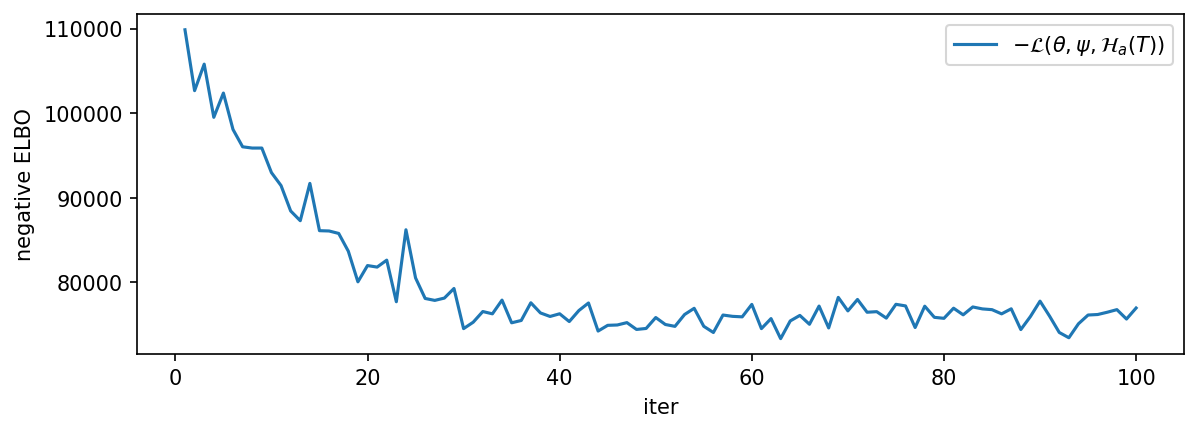

In [3]:
LSTM_a = LSTM_Encoding_Action(input_size = 4, hidden_size = 15, output_size= 8, batch_size=5, device='cuda').cuda()
LSTM_m = LSTM_Encoding_History(input_size = 10, hidden_size = 8, output_size = 4, batch_size=5, device='cuda').cuda()
a = torch.rand(size=(5,4,4)).cuda() # batch, num_predicate, length
h_a = LSTM_a.forward(a)
m = torch.rand(size=(5,3,10)).cuda()
prob = LSTM_m.forward(m,h_a)

logits = torch.log(prob)
def generate_incomplete_data(num_sample:int=10, time_horizon:float=5.0):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

action_history = generate_incomplete_data(num_sample=90,time_horizon=4.0)
learn = Logic_Model_Incomplete_Data(time_horizon=4.0,action_history=action_history,hidden_size=(15,8),output_size=(8,4),batch_size=30)
losses = learn.train_model(num_iter=100,lr=(0.01,0.002))
learn.plot_loss(losses)

[INFO] data has been generated!!!


  3%|▎         | 1/30 [00:01<00:53,  1.86s/it]

iter >> 1; loss >> [5721.6094]
model parameter $\theta$ >> [tensor([-0.2900], dtype=torch.float64, requires_grad=True), tensor([-6.8343e-11], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([-0.2900], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([0.0200], dtype=torch.float64, requires_grad=True), tensor([-0.1900], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1100], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2600], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5900], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0900], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requi

  7%|▋         | 2/30 [00:03<00:47,  1.70s/it]

iter >> 2; loss >> [5627.7397]
model parameter $\theta$ >> [tensor([-0.2800], dtype=torch.float64, requires_grad=True), tensor([0.0054], dtype=torch.float64, requires_grad=True), tensor([0.0146], dtype=torch.float64, requires_grad=True), tensor([-0.2800], dtype=torch.float64, requires_grad=True), tensor([0.0003], dtype=torch.float64, requires_grad=True), tensor([0.0297], dtype=torch.float64, requires_grad=True), tensor([-0.1800], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1200], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2700], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5800], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0800], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 10%|█         | 3/30 [00:05<00:44,  1.66s/it]

iter >> 3; loss >> [5340.889]
model parameter $\theta$ >> [tensor([-0.2700], dtype=torch.float64, requires_grad=True), tensor([0.0122], dtype=torch.float64, requires_grad=True), tensor([0.0078], dtype=torch.float64, requires_grad=True), tensor([-0.2702], dtype=torch.float64, requires_grad=True), tensor([-0.0091], dtype=torch.float64, requires_grad=True), tensor([0.0391], dtype=torch.float64, requires_grad=True), tensor([-0.1701], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1299], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2798], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5700], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0700], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 13%|█▎        | 4/30 [00:06<00:45,  1.74s/it]

iter >> 4; loss >> [5546.9023]
model parameter $\theta$ >> [tensor([-0.2599], dtype=torch.float64, requires_grad=True), tensor([0.0134], dtype=torch.float64, requires_grad=True), tensor([0.0066], dtype=torch.float64, requires_grad=True), tensor([-0.2605], dtype=torch.float64, requires_grad=True), tensor([-0.0183], dtype=torch.float64, requires_grad=True), tensor([0.0483], dtype=torch.float64, requires_grad=True), tensor([-0.1601], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1397], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2897], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5601], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0601], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 17%|█▋        | 5/30 [00:08<00:43,  1.74s/it]

iter >> 5; loss >> [5303.4546]
model parameter $\theta$ >> [tensor([-0.2499], dtype=torch.float64, requires_grad=True), tensor([0.0174], dtype=torch.float64, requires_grad=True), tensor([0.0026], dtype=torch.float64, requires_grad=True), tensor([-0.2506], dtype=torch.float64, requires_grad=True), tensor([-0.0277], dtype=torch.float64, requires_grad=True), tensor([0.0577], dtype=torch.float64, requires_grad=True), tensor([-0.1502], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1495], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.2996], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5501], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0501], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 20%|██        | 6/30 [00:10<00:40,  1.69s/it]

iter >> 6; loss >> [5490.371]
model parameter $\theta$ >> [tensor([-0.2399], dtype=torch.float64, requires_grad=True), tensor([0.0224], dtype=torch.float64, requires_grad=True), tensor([-0.0024], dtype=torch.float64, requires_grad=True), tensor([-0.2407], dtype=torch.float64, requires_grad=True), tensor([-0.0359], dtype=torch.float64, requires_grad=True), tensor([0.0659], dtype=torch.float64, requires_grad=True), tensor([-0.1403], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1591], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3094], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5402], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0402], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 23%|██▎       | 7/30 [00:11<00:38,  1.66s/it]

iter >> 7; loss >> [5091.1123]
model parameter $\theta$ >> [tensor([-0.2299], dtype=torch.float64, requires_grad=True), tensor([0.0264], dtype=torch.float64, requires_grad=True), tensor([-0.0064], dtype=torch.float64, requires_grad=True), tensor([-0.2308], dtype=torch.float64, requires_grad=True), tensor([-0.0427], dtype=torch.float64, requires_grad=True), tensor([0.0727], dtype=torch.float64, requires_grad=True), tensor([-0.1305], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1686], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3191], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5303], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0303], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 27%|██▋       | 8/30 [00:13<00:36,  1.65s/it]

iter >> 8; loss >> [5050.7686]
model parameter $\theta$ >> [tensor([-0.2200], dtype=torch.float64, requires_grad=True), tensor([0.0309], dtype=torch.float64, requires_grad=True), tensor([-0.0109], dtype=torch.float64, requires_grad=True), tensor([-0.2208], dtype=torch.float64, requires_grad=True), tensor([-0.0503], dtype=torch.float64, requires_grad=True), tensor([0.0803], dtype=torch.float64, requires_grad=True), tensor([-0.1207], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1778], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3287], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5205], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0203], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 30%|███       | 9/30 [00:15<00:36,  1.73s/it]

iter >> 9; loss >> [5273.241]
model parameter $\theta$ >> [tensor([-0.2100], dtype=torch.float64, requires_grad=True), tensor([0.0367], dtype=torch.float64, requires_grad=True), tensor([-0.0167], dtype=torch.float64, requires_grad=True), tensor([-0.2109], dtype=torch.float64, requires_grad=True), tensor([-0.0582], dtype=torch.float64, requires_grad=True), tensor([0.0882], dtype=torch.float64, requires_grad=True), tensor([-0.1108], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1869], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3385], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5107], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0104], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 33%|███▎      | 10/30 [00:17<00:35,  1.79s/it]

iter >> 10; loss >> [5208.8926]
model parameter $\theta$ >> [tensor([-0.2002], dtype=torch.float64, requires_grad=True), tensor([0.0396], dtype=torch.float64, requires_grad=True), tensor([-0.0196], dtype=torch.float64, requires_grad=True), tensor([-0.2009], dtype=torch.float64, requires_grad=True), tensor([-0.0666], dtype=torch.float64, requires_grad=True), tensor([0.0966], dtype=torch.float64, requires_grad=True), tensor([-0.1009], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.1956], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3483], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.5009], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([-0.0005], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, require

 37%|███▋      | 11/30 [00:18<00:33,  1.74s/it]

iter >> 11; loss >> [4887.9937]
model parameter $\theta$ >> [tensor([-0.1903], dtype=torch.float64, requires_grad=True), tensor([0.0425], dtype=torch.float64, requires_grad=True), tensor([-0.0225], dtype=torch.float64, requires_grad=True), tensor([-0.1909], dtype=torch.float64, requires_grad=True), tensor([-0.0749], dtype=torch.float64, requires_grad=True), tensor([0.1049], dtype=torch.float64, requires_grad=True), tensor([-0.0910], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2041], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3580], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4913], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0094], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 40%|████      | 12/30 [00:20<00:32,  1.80s/it]

iter >> 12; loss >> [4727.06]
model parameter $\theta$ >> [tensor([-0.1804], dtype=torch.float64, requires_grad=True), tensor([0.0444], dtype=torch.float64, requires_grad=True), tensor([-0.0244], dtype=torch.float64, requires_grad=True), tensor([-0.1809], dtype=torch.float64, requires_grad=True), tensor([-0.0838], dtype=torch.float64, requires_grad=True), tensor([0.1138], dtype=torch.float64, requires_grad=True), tensor([-0.0812], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2122], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3676], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4817], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0192], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 43%|████▎     | 13/30 [00:23<00:32,  1.91s/it]

iter >> 13; loss >> [4640.6973]
model parameter $\theta$ >> [tensor([-0.1704], dtype=torch.float64, requires_grad=True), tensor([0.0440], dtype=torch.float64, requires_grad=True), tensor([-0.0240], dtype=torch.float64, requires_grad=True), tensor([-0.1708], dtype=torch.float64, requires_grad=True), tensor([-0.0930], dtype=torch.float64, requires_grad=True), tensor([0.1230], dtype=torch.float64, requires_grad=True), tensor([-0.0714], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2199], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3768], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4721], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0291], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 47%|████▋     | 14/30 [00:25<00:31,  1.95s/it]

iter >> 14; loss >> [4562.0625]
model parameter $\theta$ >> [tensor([-0.1604], dtype=torch.float64, requires_grad=True), tensor([0.0450], dtype=torch.float64, requires_grad=True), tensor([-0.0250], dtype=torch.float64, requires_grad=True), tensor([-0.1608], dtype=torch.float64, requires_grad=True), tensor([-0.1021], dtype=torch.float64, requires_grad=True), tensor([0.1321], dtype=torch.float64, requires_grad=True), tensor([-0.0617], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2272], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3861], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4627], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0390], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 50%|█████     | 15/30 [00:27<00:29,  1.96s/it]

iter >> 15; loss >> [4636.545]
model parameter $\theta$ >> [tensor([-0.1505], dtype=torch.float64, requires_grad=True), tensor([0.0433], dtype=torch.float64, requires_grad=True), tensor([-0.0233], dtype=torch.float64, requires_grad=True), tensor([-0.1507], dtype=torch.float64, requires_grad=True), tensor([-0.1113], dtype=torch.float64, requires_grad=True), tensor([0.1413], dtype=torch.float64, requires_grad=True), tensor([-0.0520], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2339], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.3951], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4533], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0488], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 53%|█████▎    | 16/30 [00:28<00:26,  1.87s/it]

iter >> 16; loss >> [4536.619]
model parameter $\theta$ >> [tensor([-0.1405], dtype=torch.float64, requires_grad=True), tensor([0.0419], dtype=torch.float64, requires_grad=True), tensor([-0.0219], dtype=torch.float64, requires_grad=True), tensor([-0.1407], dtype=torch.float64, requires_grad=True), tensor([-0.1209], dtype=torch.float64, requires_grad=True), tensor([0.1509], dtype=torch.float64, requires_grad=True), tensor([-0.0422], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2402], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4041], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4440], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0586], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 57%|█████▋    | 17/30 [00:30<00:23,  1.83s/it]

iter >> 17; loss >> [4608.754]
model parameter $\theta$ >> [tensor([-0.1306], dtype=torch.float64, requires_grad=True), tensor([0.0386], dtype=torch.float64, requires_grad=True), tensor([-0.0186], dtype=torch.float64, requires_grad=True), tensor([-0.1307], dtype=torch.float64, requires_grad=True), tensor([-0.1297], dtype=torch.float64, requires_grad=True), tensor([0.1597], dtype=torch.float64, requires_grad=True), tensor([-0.0324], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2460], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4132], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4348], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0684], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 60%|██████    | 18/30 [00:32<00:21,  1.80s/it]

iter >> 18; loss >> [4565.411]
model parameter $\theta$ >> [tensor([-0.1206], dtype=torch.float64, requires_grad=True), tensor([0.0372], dtype=torch.float64, requires_grad=True), tensor([-0.0172], dtype=torch.float64, requires_grad=True), tensor([-0.1208], dtype=torch.float64, requires_grad=True), tensor([-0.1389], dtype=torch.float64, requires_grad=True), tensor([0.1689], dtype=torch.float64, requires_grad=True), tensor([-0.0226], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2511], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4225], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4258], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0782], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 63%|██████▎   | 19/30 [00:33<00:19,  1.78s/it]

iter >> 19; loss >> [4432.659]
model parameter $\theta$ >> [tensor([-0.1107], dtype=torch.float64, requires_grad=True), tensor([0.0350], dtype=torch.float64, requires_grad=True), tensor([-0.0150], dtype=torch.float64, requires_grad=True), tensor([-0.1109], dtype=torch.float64, requires_grad=True), tensor([-0.1469], dtype=torch.float64, requires_grad=True), tensor([0.1769], dtype=torch.float64, requires_grad=True), tensor([-0.0127], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2557], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4316], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4169], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0880], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 67%|██████▋   | 20/30 [00:35<00:17,  1.79s/it]

iter >> 20; loss >> [4311.5337]
model parameter $\theta$ >> [tensor([-0.1008], dtype=torch.float64, requires_grad=True), tensor([0.0324], dtype=torch.float64, requires_grad=True), tensor([-0.0124], dtype=torch.float64, requires_grad=True), tensor([-0.1011], dtype=torch.float64, requires_grad=True), tensor([-0.1552], dtype=torch.float64, requires_grad=True), tensor([0.1852], dtype=torch.float64, requires_grad=True), tensor([-0.0029], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2597], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4408], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.4081], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.0977], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires

 70%|███████   | 21/30 [00:37<00:15,  1.78s/it]

iter >> 21; loss >> [4467.709]
model parameter $\theta$ >> [tensor([-0.0909], dtype=torch.float64, requires_grad=True), tensor([0.0300], dtype=torch.float64, requires_grad=True), tensor([-0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.0912], dtype=torch.float64, requires_grad=True), tensor([-0.1638], dtype=torch.float64, requires_grad=True), tensor([0.1938], dtype=torch.float64, requires_grad=True), tensor([0.0070], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2630], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4498], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3994], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1075], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 73%|███████▎  | 22/30 [00:39<00:14,  1.81s/it]

iter >> 22; loss >> [4395.932]
model parameter $\theta$ >> [tensor([-0.0811], dtype=torch.float64, requires_grad=True), tensor([0.0287], dtype=torch.float64, requires_grad=True), tensor([-0.0087], dtype=torch.float64, requires_grad=True), tensor([-0.0813], dtype=torch.float64, requires_grad=True), tensor([-0.1729], dtype=torch.float64, requires_grad=True), tensor([0.2029], dtype=torch.float64, requires_grad=True), tensor([0.0168], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2658], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4589], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3909], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1172], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 77%|███████▋  | 23/30 [00:41<00:12,  1.81s/it]

iter >> 23; loss >> [4366.562]
model parameter $\theta$ >> [tensor([-0.0712], dtype=torch.float64, requires_grad=True), tensor([0.0253], dtype=torch.float64, requires_grad=True), tensor([-0.0053], dtype=torch.float64, requires_grad=True), tensor([-0.0714], dtype=torch.float64, requires_grad=True), tensor([-0.1819], dtype=torch.float64, requires_grad=True), tensor([0.2119], dtype=torch.float64, requires_grad=True), tensor([0.0266], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2680], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4679], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3825], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1268], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 80%|████████  | 24/30 [00:42<00:10,  1.77s/it]

iter >> 24; loss >> [4218.8887]
model parameter $\theta$ >> [tensor([-0.0614], dtype=torch.float64, requires_grad=True), tensor([0.0207], dtype=torch.float64, requires_grad=True), tensor([-0.0007], dtype=torch.float64, requires_grad=True), tensor([-0.0615], dtype=torch.float64, requires_grad=True), tensor([-0.1908], dtype=torch.float64, requires_grad=True), tensor([0.2208], dtype=torch.float64, requires_grad=True), tensor([0.0364], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2696], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4768], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3743], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1365], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

 83%|████████▎ | 25/30 [00:44<00:08,  1.78s/it]

iter >> 25; loss >> [4278.9023]
model parameter $\theta$ >> [tensor([-0.0516], dtype=torch.float64, requires_grad=True), tensor([0.0168], dtype=torch.float64, requires_grad=True), tensor([0.0032], dtype=torch.float64, requires_grad=True), tensor([-0.0517], dtype=torch.float64, requires_grad=True), tensor([-0.2000], dtype=torch.float64, requires_grad=True), tensor([0.2300], dtype=torch.float64, requires_grad=True), tensor([0.0462], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2706], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4860], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3663], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1461], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 87%|████████▋ | 26/30 [00:46<00:07,  1.82s/it]

iter >> 26; loss >> [4147.0894]
model parameter $\theta$ >> [tensor([-0.0419], dtype=torch.float64, requires_grad=True), tensor([0.0127], dtype=torch.float64, requires_grad=True), tensor([0.0073], dtype=torch.float64, requires_grad=True), tensor([-0.0418], dtype=torch.float64, requires_grad=True), tensor([-0.2092], dtype=torch.float64, requires_grad=True), tensor([0.2392], dtype=torch.float64, requires_grad=True), tensor([0.0560], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2712], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.4951], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3584], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1558], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_g

 90%|█████████ | 27/30 [00:48<00:05,  1.82s/it]

iter >> 27; loss >> [4208.442]
model parameter $\theta$ >> [tensor([-0.0320], dtype=torch.float64, requires_grad=True), tensor([0.0079], dtype=torch.float64, requires_grad=True), tensor([0.0121], dtype=torch.float64, requires_grad=True), tensor([-0.0321], dtype=torch.float64, requires_grad=True), tensor([-0.2185], dtype=torch.float64, requires_grad=True), tensor([0.2485], dtype=torch.float64, requires_grad=True), tensor([0.0658], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2713], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5042], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3508], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1654], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gr

 93%|█████████▎| 28/30 [00:50<00:03,  1.80s/it]

iter >> 28; loss >> [3869.64]
model parameter $\theta$ >> [tensor([-0.0220], dtype=torch.float64, requires_grad=True), tensor([0.0016], dtype=torch.float64, requires_grad=True), tensor([0.0184], dtype=torch.float64, requires_grad=True), tensor([-0.0224], dtype=torch.float64, requires_grad=True), tensor([-0.2281], dtype=torch.float64, requires_grad=True), tensor([0.2581], dtype=torch.float64, requires_grad=True), tensor([0.0755], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2709], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5132], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3433], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1749], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_gra

 97%|█████████▋| 29/30 [00:51<00:01,  1.81s/it]

iter >> 29; loss >> [3880.9768]
model parameter $\theta$ >> [tensor([-0.0123], dtype=torch.float64, requires_grad=True), tensor([-0.0042], dtype=torch.float64, requires_grad=True), tensor([0.0242], dtype=torch.float64, requires_grad=True), tensor([-0.0127], dtype=torch.float64, requires_grad=True), tensor([-0.2378], dtype=torch.float64, requires_grad=True), tensor([0.2678], dtype=torch.float64, requires_grad=True), tensor([0.0853], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2701], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5222], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3360], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1844], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

100%|██████████| 30/30 [00:53<00:00,  1.79s/it]


iter >> 30; loss >> [3668.7031]
model parameter $\theta$ >> [tensor([-0.0024], dtype=torch.float64, requires_grad=True), tensor([-0.0098], dtype=torch.float64, requires_grad=True), tensor([0.0298], dtype=torch.float64, requires_grad=True), tensor([-0.0030], dtype=torch.float64, requires_grad=True), tensor([-0.2474], dtype=torch.float64, requires_grad=True), tensor([0.2774], dtype=torch.float64, requires_grad=True), tensor([0.0950], dtype=torch.float64, requires_grad=True), tensor([0.1000], dtype=torch.float64, requires_grad=True), tensor([-0.2690], dtype=torch.float64, requires_grad=True), tensor([0.0100], dtype=torch.float64, requires_grad=True), tensor([-0.5310], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_grad=True), tensor([-0.3290], dtype=torch.float64, requires_grad=True), tensor([0.8000], dtype=torch.float64, requires_grad=True), tensor([0.1938], dtype=torch.float64, requires_grad=True), tensor([0.0500], dtype=torch.float64, requires_

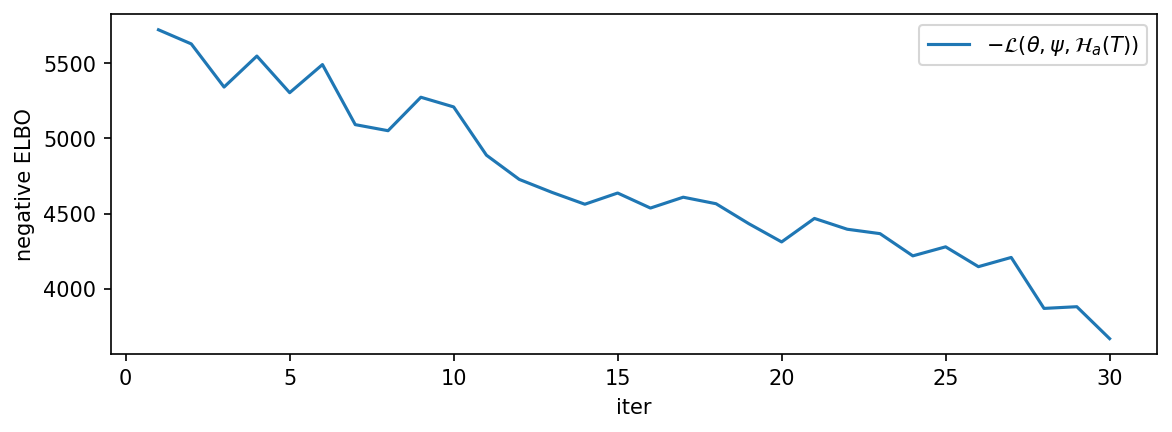

In [7]:
LSTM_a = LSTM_Encoding_Action(input_size = 4, hidden_size = 15, output_size= 8, batch_size=5, device='cuda').cuda()
LSTM_m = LSTM_Encoding_History(input_size = 10, hidden_size = 8, output_size = 4, batch_size=5, device='cuda').cuda()
a = torch.rand(size=(5,4,4)).cuda() # batch, num_predicate, length
h_a = LSTM_a.forward(a)
m = torch.rand(size=(5,3,10)).cuda()
prob = LSTM_m.forward(m,h_a)

logits = torch.log(prob)
def generate_incomplete_data(num_sample:int=10, time_horizon:float=5.0):
        gen = Logic_Model_Generator()
        data = gen.generate_data(num_sample=num_sample, time_horizon=time_horizon)
        action_history = {}
        for i in range(num_sample):
            action_history_ = dict([(key, data[i][key]) for key in [3,4,5,6]])
            action_history[i] = action_history_
        #NOTE: info
        print('[INFO] data has been generated!!!')
        return action_history

action_history = generate_incomplete_data(num_sample=20,time_horizon=1.0)
learn = Logic_Model_Incomplete_Data(time_horizon=1.0,action_history=action_history,hidden_size=(15,20),output_size=(20,4),batch_size=20)
losses = learn.train_model(num_iter=30,lr=(0.01,0.003))
learn.plot_loss(losses)